Find a list of all data

In [1]:
import pandas as pd
import seaborn as sns
excel_data = pd.ExcelFile('/Users/chencheng/Downloads/Moving annual rent by suburb - March quarter 2023.xlsx')
# Check sheet names to understand the structure of the file
sheet_names = excel_data. sheet_names
sheet_names

['1 bedroom flat',
 '2 bedroom flat',
 '3 bedroom flat',
 '2 bedroom house',
 '3 bedroom house',
 '4 bedroom house',
 'All properties']

Use the method of "ffill" to fill in the missing value (NaN) in the first column of the data box, that is, fill in the missing value with the previous non-empty value.

In [162]:
rent_1b = pd.read_excel( '/Users/chencheng/Downloads/Moving annual rent by suburb - March quarter 2023.xlsx', sheet_name='1 bedroom flat', header=[1,2])
rent_1b.iloc[:,0] = rent_1b. iloc[:,0]. fillna(method='ffill')
rent_1b. head

<bound method NDFrame.head of              1 bedroom flat                                        Mar 2000  \
                      regen                                 suburb    Count   
0           Inner Melbourne  Albert Park-Middle Park-West St Kilda      352   
1           Inner Melbourne                               Armadale      210   
2           Inner Melbourne                          Carlton North       87   
3           Inner Melbourne                      Carlton-Parkville      303   
4           Inner Melbourne                        CBD-St Kilda Rd      755   
..                      ...                                    ...      ...   
154  Other Regional Centres                            Wanagaratta       51   
155  Other Regional Centres                               Warragul       13   
156  Other Regional Centres                            Warrnambool      113   
157  Other Regional Centres                                Wodonga       77   
158  Other Regional Ce

Merge the data in a multi-worksheet Excel file into a structured long format data box to facilitate data analysis. By reshaping the data of each worksheet into a long format, time series analysis and comparison of different attribute types can be carried out conveniently.

In [163]:
def merge_sheets(file_path):
    merged_df = pd.DataFrame()
    excel_data = pd.ExcelFile(file_path)
    
    sheet_names = excel_data.sheet_names
    for sheet_name in sheet_names:
        df = pd.read_excel(file_path, sheet_name=sheet_name, header=[1,2])
        df.iloc[:,0] = df.iloc[:,0].fillna(method='ffill')
        merged_df = pd.concat([merged_df, melt_df(df, sheet_name)], ignore_index=True)
    
    return merged_df

def melt_df(df, sheet_name):
    new_columns = df.columns.to_list()
    
    df_count = pd.melt(df,
                       id_vars=new_columns[:2],
                       value_vars=new_columns[2::2],
                       var_name='Date',
                       value_name='Count')
    
    df_count.columns.values[0:2] = ['Region', 'Suburb']
    
    df_median = pd.melt(df,
                        id_vars=new_columns[:2],
                        value_vars=new_columns[3::2],
                        var_name='Date',
                        value_name='Median')
    
    df_median.columns.values[0:2] = ['Region', 'Suburb']
    
    # print(df_count.shape)
    # print(df_median.shape)
    
    df_long = pd.merge(df_count, df_median, how='left')
    df_long['PropertyType'] = sheet_name
    df_long['Median'] = pd.to_numeric(df_long['Median'], errors='coerce')
    df_long['Count'] = pd.to_numeric(df_long['Count'], errors='coerce')
    df_long['Median'] = df_long.groupby('Suburb')['Median'].ffill()
    df_long['Count'] = df_long.groupby('Suburb')['Count'].ffill()
    df_long['Median'] = df_long.groupby('Suburb')['Median'].ffill()
    df_long['Count'] = df_long.groupby('Suburb')['Count'].ffill()
    
    return df_long

In [164]:
merged_df = merge_sheets('/Users/chencheng/Downloads/Moving annual rent by suburb - March quarter 2023.xlsx')

Save the data locally

In [165]:
merged_df.to_csv('/Users/chencheng/Downloads/cleaned_rent.csv')

In [166]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103509 entries, 0 to 103508
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Region        103509 non-null  object 
 1   Suburb        103509 non-null  object 
 2   Date          103509 non-null  object 
 3   Count         101739 non-null  float64
 4   Median        101739 non-null  float64
 5   PropertyType  103509 non-null  object 
dtypes: float64(2), object(4)
memory usage: 4.7+ MB


Use exal to change the date format to YYYY/MM/DD for the data saved locally.

In [167]:
merged_df = pd.read_csv("/Users/chencheng/Downloads/cleaned_rent2.csv")

The 'Date' column in the merged_df data box is converted to date and time format

In [168]:
# Convert the 'Date' column to datetime format
merged_df['Date'] = pd.to_datetime(merged_df['Date'], format='%Y-%m-%d')

In [149]:

# Filter out rows where 'Suburb' is 'Group Total'
#merged_df = merged_df[merged_df['Suburb'] != 'Group Total']

# Assign the 'Region' values for rows with 'Suburb' as 'Group Total'
##merged_df.loc[merged_df['Suburb'] == 'Group Total', 'Suburb'] = merged_df['Region']

# Group by 'Region', 'Date', and calculate the mean for 'Median'
#region_rent = merged_df[['Region', 'Date', 'Median']].groupby(['Region', 'Date']).mean()

# Plotting the data using seaborn and matplotlib
#import seaborn as sns
#import matplotlib.pyplot as plt

#plt.figure(figsize=(22, 16))
#sns.lineplot(data=region_rent, x='Date', y='Median', hue='Region')
#plt.show()

This code uses the SARIMA model to predict future rent trends in different regions, suburbs and property types.	
Use the SARIMAX model to fit the time series data, where order and seasonal_order specify the model parameters, (0, 1, 1) represents the ARIMA model parameters of the non-seasonal part, and (0, 1, 1, 4) represents the parameters of the seasonal part, The cycle is 4 quarters.
Predict the rent trend in the next 20 quarters.

In [169]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')

# Assuming merged_df is already defined and formatted correctly
# Ensure the 'Date' column is in the correct datetime format, and filter out unreasonable year data
merged_df['Date'] = pd.to_datetime(merged_df['Date'], errors='coerce')
merged_df = merged_df.dropna(subset=['Date'])
merged_df = merged_df[merged_df['Date'].dt.year >= 1970]

# Dictionary to store prediction results
predictions_grouped = {}

# Loop through each unique combination of region, suburb, and property type to predict future rent trends
for (region, suburb, property_type), group_data in merged_df.groupby(['Region', 'Suburb', 'PropertyType']):
    
    group_data = group_data.set_index('Date')  # Set the 'Date' column as the index
    
    # Use the 'Median' column as time series data
    ts = group_data['Median'].astype(float)
    
    # Ensure the data is sorted by date
    ts = ts.sort_index()

    try:
        # Fit the SARIMA model, adjusting model parameters as needed
        model = SARIMAX(ts, order=(0, 1, 1), seasonal_order=(0, 1, 1, 4), trend='n')
        model_fit = model.fit(disp=False)

        # Predict for the next 20 quarters
        forecast_steps = 20
        forecast = model_fit.get_forecast(steps=forecast_steps).predicted_mean

        # Limit the forecasted values: No more than 5% growth per quarter (max 20% per year)
        max_growth_per_quarter = 1.05  # Maximum 5% growth per quarter
        adjusted_forecast = [ts.iloc[-1]]  # Start from the last actual value
        
        for i in range(1, len(forecast)):
            # Ensure the growth rate per quarter does not exceed 5%
            next_value = min(forecast[i], adjusted_forecast[-1] * max_growth_per_quarter)
            adjusted_forecast.append(next_value)

        # Store the adjusted forecasted results
        predictions_grouped[(region, suburb, property_type)] = adjusted_forecast

    except ValueError as e:
        print(f"Error processing {region}, {suburb}, {property_type}: {e}")
        continue

# Convert the prediction results to a DataFrame for display
predictions_grouped_df = pd.DataFrame(predictions_grouped)



Predict the future rental trend of one-bedroom apartments in the South Bank area, compare it with the last known actual rent value, and analyze the direction and magnitude of future rent changes. Compare and evaluate the accuracy and rationality of the forecast.

In [151]:
# Filter the predictions for Southbank 1 bedroom flat
southbank_forecast = predictions_grouped_df[('Inner Melbourne', 'Southbank', 'All properties')]

# Extract the last known actual value from the merged_df
southbank_actual_last_value = merged_df[(merged_df['Region'] == 'Inner Melbourne') &
                                        (merged_df['Suburb'] == 'Southbank') &
                                        (merged_df['PropertyType'] == 'All properties')]['Median'].iloc[-1]

# Print the forecasted values and the last actual value
print("Southbank 1 Bedroom Flat Forecast (Next 20 Quarters):")
print(southbank_forecast)
print("\nLast Actual Value for Southbank 1 Bedroom Flat:")
print(southbank_actual_last_value)

Southbank 1 Bedroom Flat Forecast (Next 20 Quarters):
0     553.000000
1     569.189784
2     570.712266
3     575.089564
4     577.820272
5     579.472387
6     580.994869
7     585.372168
8     588.102875
9     589.754991
10    591.277473
11    595.654771
12    598.385479
13    600.037595
14    601.560076
15    605.937375
16    608.668083
17    610.320198
18    611.842680
19    616.219979
Name: (Inner Melbourne, Southbank, All properties), dtype: float64

Last Actual Value for Southbank 1 Bedroom Flat:
553.0


Use the SARIMA model to predict future rent trends in different areas, suburbs and property types, and evaluate the prediction accuracy of the model.

In [152]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Initialize a dictionary to store accuracy results
accuracy_results = {}
predictions_grouped = {}

# Convert 'Date' column to datetime and filter out invalid dates
merged_df['Date'] = pd.to_datetime(merged_df['Date'], errors='coerce')
merged_df = merged_df.dropna(subset=['Date'])

# Loop through each unique combination of suburb and property type to predict future rent trends
for (region, suburb, property_type), group_data in merged_df.groupby(['Region', 'Suburb', 'PropertyType']):

    # Set the 'Date' column as index
    group_data = group_data.set_index('Date')
    
    # Split the data into training (before 2017) and validation sets (2017-2019)
    train_data = group_data[group_data.index < '2017-01-01']
    validation_data = group_data[(group_data.index >= '2017-01-01') & (group_data.index < '2020-01-01')]

    # Use the 'Median' column as time series data for both training and validation
    ts_train = train_data['Median'].astype(float)
    ts_validation = validation_data['Median'].astype(float)
    
    # Skip if insufficient data for training or validation
    if len(ts_train) < 8 or len(ts_validation) == 0:
        print(f"Skipping {region}, {suburb}, {property_type} due to insufficient training or validation data.")
        continue

    try:
        # Fit the SARIMA model (Seasonal order = (0, 1, 1, 4) for quarterly data)
        model = SARIMAX(ts_train, order=(0, 1, 1), seasonal_order=(0, 1, 1, 4), trend='n')
        model_fit = model.fit(disp=False)

        # Predict the data for the same length as the validation set (2017-2019)
        forecast_steps = len(ts_validation)
        forecast = model_fit.get_forecast(steps=forecast_steps).predicted_mean

        # Limit the growth rate to a maximum of 5% per quarter
        max_growth_per_quarter = 1.05  # Maximum 5% growth per quarter
        adjusted_forecast = [ts_train.iloc[-1]]  # Start with the last actual training value
        
        for i in range(1, len(forecast)):
            # Limit the forecast growth to 5% per quarter
            next_value = min(forecast.iloc[i], adjusted_forecast[-1] * max_growth_per_quarter)
            adjusted_forecast.append(next_value)
        
        forecast.index = ts_validation.index
        adjusted_forecast = pd.Series(adjusted_forecast, index=ts_validation.index)

        # Store the predicted results for comparison with validation data
        predictions_grouped[(region, suburb, property_type)] = adjusted_forecast

        # Compare the forecast with the validation set (2017-2019)
        validation_comparison = pd.DataFrame({
            'Actual': ts_validation,
            'Forecast': adjusted_forecast
        })

        # Calculate the average absolute error (MAE) and mean square error (MSE)
        mae = mean_absolute_error(ts_validation, adjusted_forecast)
        mse = mean_squared_error(ts_validation, adjusted_forecast)

        # Store the error results
        accuracy_results[(region, suburb, property_type)] = {'MAE': mae, 'MSE': mse}

        print(f"Validation results for {region}, {suburb}, {property_type}:")
        print(validation_comparison)

    except ValueError as e:
        print(f"Error processing {region}, {suburb}, {property_type}: {e}")
        continue

# Convert accuracy results to a DataFrame for display
accuracy_df = pd.DataFrame(accuracy_results).T.reset_index()
accuracy_df.columns = ['Region', 'Suburb', 'PropertyType', 'MAE', 'MSE']

# Display accuracy results DataFrame
print(accuracy_df)

Validation results for Ballarat, Ballarat, 1 bedroom flat:
            Actual    Forecast
Date                          
2017-03-01   170.0  170.000000
2017-06-01   170.0  173.208158
2017-09-01   175.0  174.502292
2017-12-01   178.0  175.678749
2018-03-01   180.0  177.759724
2018-06-01   180.0  178.642064
2018-09-01   180.0  179.936198
2018-12-01   185.0  181.112656
2019-03-01   190.0  183.193630
2019-06-01   190.0  184.075970
2019-09-01   190.0  185.370104
2019-12-01   190.0  186.546562
Validation results for Ballarat, Ballarat, 2 bedroom flat:
            Actual    Forecast
Date                          
2017-03-01   245.0  245.000000
2017-06-01   250.0  248.592054
2017-09-01   250.0  249.539556
2017-12-01   250.0  251.415622
2018-03-01   250.0  253.769187
2018-06-01   250.0  255.480315
2018-09-01   250.0  256.427817
2018-12-01   255.0  258.303883
2019-03-01   260.0  260.657448
2019-06-01   260.0  262.368576
2019-09-01   260.0  263.316078
2019-12-01   260.0  265.192144
Validation res

In [153]:
accuracy_df.head(20)

Region                 Suburb     PropertyType        MAE         MSE
0   Ballarat               Ballarat   1 bedroom flat   2.865851   12.724126
1   Ballarat               Ballarat   2 bedroom flat   2.816622   12.055711
2   Ballarat               Ballarat  2 bedroom house   4.244115   25.848180
3   Ballarat               Ballarat   3 bedroom flat   6.518589   54.498449
4   Ballarat               Ballarat  3 bedroom house  11.344964  223.376100
5   Ballarat               Ballarat  4 bedroom house   4.628516   31.156986
6   Ballarat               Ballarat   All properties   7.652039  111.205257
7   Ballarat            Group Total   1 bedroom flat   3.554487   20.528879
8   Ballarat            Group Total   2 bedroom flat   2.165060    7.545452
9   Ballarat            Group Total  2 bedroom house   4.893833   32.952324
10  Ballarat            Group Total   3 bedroom flat   3.838000   22.361822
11  Ballarat            Group Total  3 bedroom house  15.551826  332.572952
12  Ballarat            Group Total  4 bedroom house  16.680708  422.205802
13  Ballarat            Group Total   All properties  12.655826  229.774512
14  Ballarat  Mount Clear-Buninyong   1 bedroom flat   7.327979   84.019496
15  Ballarat  Mount Clear-Buninyong   2 bedroom flat   8.709257   91.166318
16  Ballarat  Mount Clear-Buninyong  2 bedroom house  17.053602  463.332528
17  Ballarat  Mount Clear-Buninyong   3 bedroom flat   5.674319   52.244766
18  Ballarat  Mount Clear-Buninyong  3 bedroom house   6.561905   55.593135
19  Ballarat  Mount Clear-Buninyong  4 bedroom house  11.927220  173.890274

Calculate the average prediction error (MAE and MSE) of each property type (PropertyType)

In [154]:
# Calculate the average MAE and MSE of each PropertyType
average_mae_mse_by_propertytype = accuracy_df.groupby('PropertyType').agg({'MAE': 'mean', 'MSE': 'mean'}).reset_index()

# Output results
print(average_mae_mse_by_propertytype)

      PropertyType        MAE          MSE
0   1 bedroom flat  11.250596   294.113120
1   2 bedroom flat   8.308857   138.947585
2  2 bedroom house  12.125531   361.950878
3   3 bedroom flat  14.544941   503.124440
4  3 bedroom house  13.712026   788.111309
5  4 bedroom house  26.184167  2553.064216
6   All properties   9.185044   166.184036


Draw a bar chart of the average forecast error (MAE and MSE) to show the prediction accuracy of different property types.

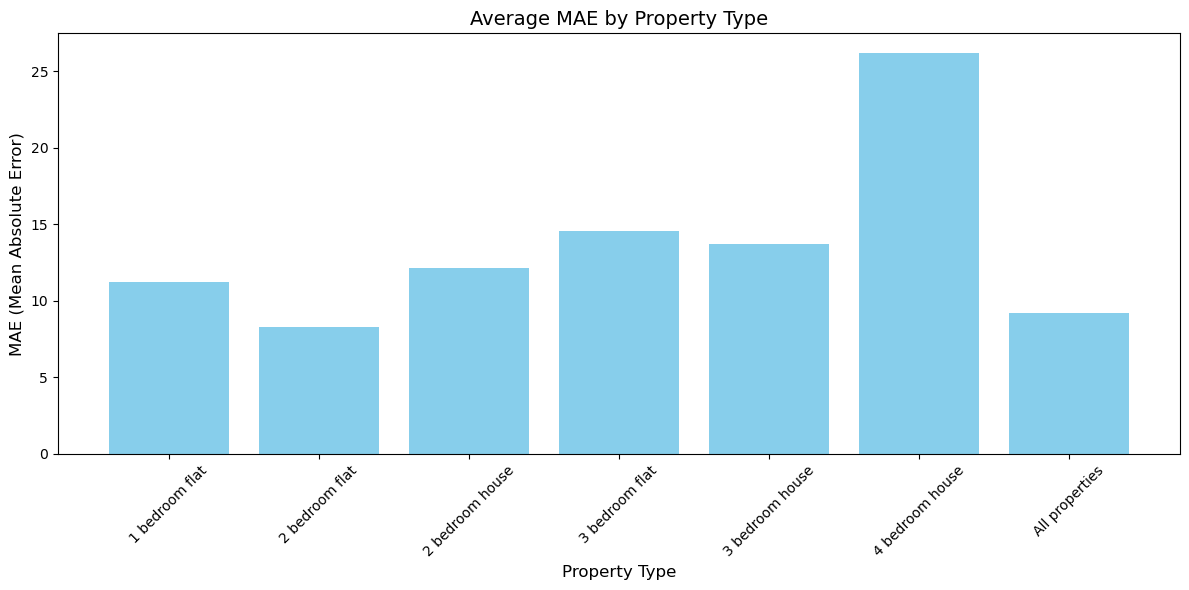

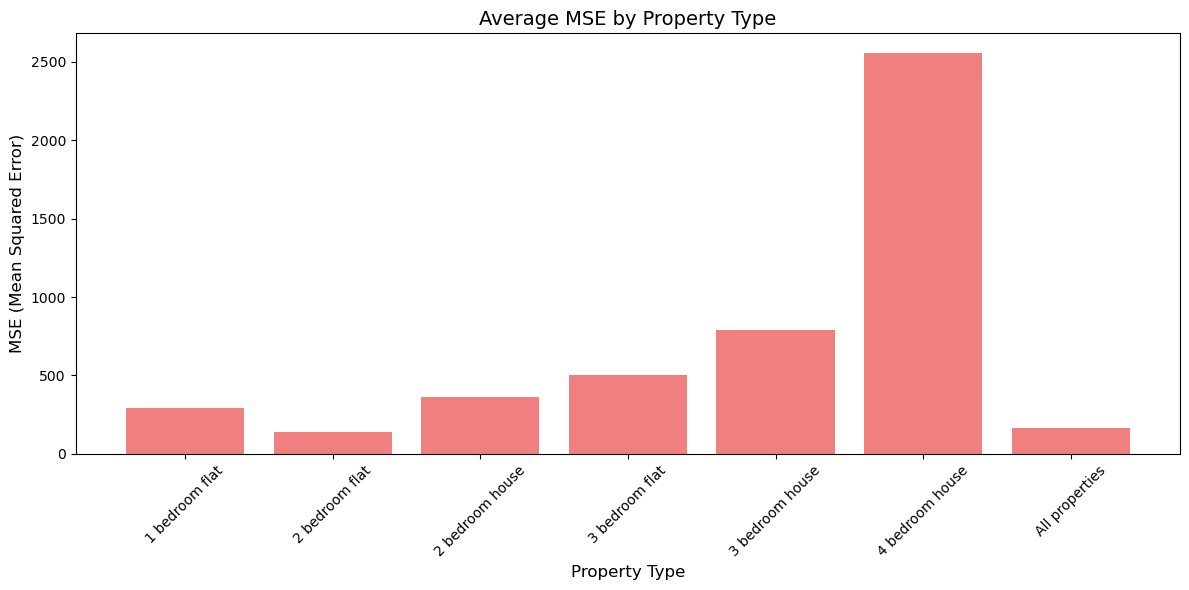

In [155]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Draw a bar chart of MAE
plt.bar(average_mae_mse_by_propertytype['PropertyType'], average_mae_mse_by_propertytype['MAE'], color='skyblue', label='MAE')

# Add chart labels and titles
plt.xlabel('Property Type', fontsize=12)
plt.ylabel('MAE (Mean Absolute Error)', fontsize=12)
plt.title('Average MAE by Property Type', fontsize=14)
plt.xticks(rotation=45)

# Display the chart
plt.tight_layout()
plt.show()

# Set the size of the chart
plt.figure(figsize=(12, 6))

# Draw a bar chart of MSE
plt.bar(average_mae_mse_by_propertytype['PropertyType'], average_mae_mse_by_propertytype['MSE'], color='lightcoral', label='MSE')
# Add chart labels and titles
plt.xlabel('Property Type', fontsize=12)
plt.ylabel('MSE (Mean Squared Error)', fontsize=12)
plt.title('Average MSE by Property Type', fontsize=14)
plt.xticks(rotation=45)

# Display the chart
plt.tight_layout()
plt.show()

In [157]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Dictionary to store predictions for each region, suburb, and property type
predictions_grouped = {}

# Convert 'Date' column to datetime and filter data before 2020
merged_df['Date'] = pd.to_datetime(merged_df['Date'], errors='coerce')
merged_df = merged_df.dropna(subset=['Date'])

# Create an empty DataFrame to store the predictions
merged_df_2019 = pd.DataFrame()

# Loop through each unique combination of suburb and property type to predict future rent trends
for (region, suburb, property_type), group_data in merged_df.groupby(['Region', 'Suburb', 'PropertyType']):

    # Set the 'Date' column as index
    group_data = group_data.set_index('Date')
    
    # Use data before 2020 for model training (up to the end of 2019)
    train_data = group_data[group_data.index < '2020-01-01']

    # Use the 'Median' column as time series data for training
    ts_train = train_data['Median'].astype(float)

    # Check if the training data is sufficient
    if len(ts_train) < 8:  
        print(f"Skipping {region}, {suburb}, {property_type} due to insufficient training data.")
        continue

    try:
        # Fit the SARIMA model with the specified parameters
        model = SARIMAX(ts_train, order=(0, 1, 1), seasonal_order=(0, 1, 1, 4), trend='n')
        model_fit = model.fit(disp=False)

        # Predict the data for the next 9 years (9 years * 4 quarters = 36 quarters)
        forecast_steps = 36
        forecast = model_fit.get_forecast(steps=forecast_steps).predicted_mean

        # Limit the growth rate to a maximum of 5% per quarter
        max_growth_per_quarter = 1.05  # Maximum 5% growth per quarter
        adjusted_forecast = [ts_train.iloc[-1]]  # Start with the last actual training value

        for i in range(1, len(forecast)):
            # Limit the forecast growth to 5% per quarter
            next_value = min(forecast.iloc[i], adjusted_forecast[-1] * max_growth_per_quarter)
            adjusted_forecast.append(next_value)

        # Generate future dates starting from 2020-01-01 for the next 9 years (36 quarters)
        last_date = train_data.index.max()
        forecast_dates = pd.date_range(start=last_date + pd.DateOffset(months=3), periods=forecast_steps, freq='Q')

        # Create a DataFrame with the adjusted prediction results
        predicted_df = pd.DataFrame({
            'Region': region,
            'Suburb': suburb,
            'PropertyType': property_type,
            'Date': forecast_dates,
            'Forecast': adjusted_forecast  # Use the adjusted forecast with growth limitation
        })

        # Append the predictions to the final DataFrame
        merged_df_2019 = pd.concat([merged_df_2019, predicted_df], ignore_index=True)

    except ValueError as e:
        print(f"Error processing {region}, {suburb}, {property_type}: {e}")
        continue

# Now you have the predicted results stored in merged_df_2019 with the growth rate limited to 5% per quarter
print(merged_df_2019)

                   Region                  Suburb    PropertyType       Date  \
0                Ballarat                Ballarat  1 bedroom flat 2020-03-31   
1                Ballarat                Ballarat  1 bedroom flat 2020-06-30   
2                Ballarat                Ballarat  1 bedroom flat 2020-09-30   
3                Ballarat                Ballarat  1 bedroom flat 2020-12-31   
4                Ballarat                Ballarat  1 bedroom flat 2021-03-31   
...                   ...                     ...             ...        ...   
40063  Southern Melbourne  Murrumbeena-Hughesdale  All properties 2027-12-31   
40064  Southern Melbourne  Murrumbeena-Hughesdale  All properties 2028-03-31   
40065  Southern Melbourne  Murrumbeena-Hughesdale  All properties 2028-06-30   
40066  Southern Melbourne  Murrumbeena-Hughesdale  All properties 2028-09-30   
40067  Southern Melbourne  Murrumbeena-Hughesdale  All properties 2028-12-31   

         Forecast  
0      190.000000  

Draw a comparison chart of the trend of the epidemic-affected trend of rents in all types of properties in the Southbank area and the trend of years not affected by the epidemic.

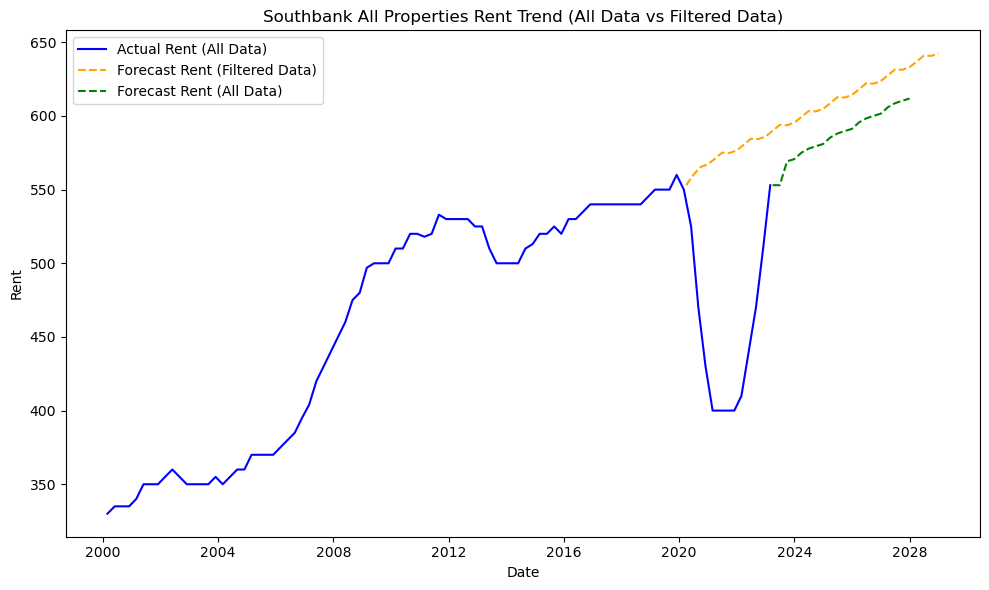

In [158]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert 'Date' column to datetime format and remove invalid dates for both datasets
merged_df['Date'] = pd.to_datetime(merged_df['Date'], errors='coerce')
merged_df = merged_df.dropna(subset=['Date'])

# Filter the actual data for 'Inner Melbourne', 'Southbank', and 'All properties'
group_data_all = merged_df[(merged_df['Region'] == 'Inner Melbourne') & 
                           (merged_df['Suburb'] == 'Southbank') & 
                           (merged_df['PropertyType'] == 'All properties')]

# Get the filtered forecast data from merged_df_2019
group_data_filtered = merged_df_2019[(merged_df_2019['Region'] == 'Inner Melbourne') & 
                                     (merged_df_2019['Suburb'] == 'Southbank') & 
                                     (merged_df_2019['PropertyType'] == 'All properties')]

# Get the last actual date and value
last_date = group_data_all['Date'].max()
last_value = group_data_all['Median'].iloc[-1]  # Last actual value

# Get the first date of the filtered data and align it with the last actual date
start_date_filtered = group_data_filtered['Date'].min()

# Generate forecast dates for the filtered forecast, ensuring they match the data
forecast_steps_filtered = len(group_data_filtered)
forecast_dates_filtered = pd.date_range(start=start_date_filtered, periods=forecast_steps_filtered, freq='Q')

# Get the filtered forecast values from merged_df_2019
forecast_values_filtered = group_data_filtered['Forecast'].values

# Ensure the first forecast value connects with the last actual value
forecast_values_filtered = [last_value] + list(forecast_values_filtered)

# Trim forecast values to match the length of forecast_dates_filtered
forecast_values_filtered = forecast_values_filtered[:len(forecast_dates_filtered)]

# Get the unfiltered forecast values starting from March 2023
forecast_dates_all = pd.date_range(start='2023-03-01', periods=len(predictions_grouped_df[('Inner Melbourne', 'Southbank', 'All properties')]), freq='Q')
forecast_values_all = predictions_grouped_df[('Inner Melbourne', 'Southbank', 'All properties')]

# Ensure the first unfiltered forecast value connects with the last actual value
forecast_values_all = [last_value] + list(forecast_values_all)
forecast_values_all = forecast_values_all[:len(forecast_dates_all)]

# Plot actual and forecast data
plt.figure(figsize=(10, 6))
plt.plot(group_data_all['Date'], group_data_all['Median'], label='Actual Rent (All Data)', color='blue')

# Plot the filtered forecast data
plt.plot(forecast_dates_filtered, forecast_values_filtered, label='Forecast Rent (Filtered Data)', linestyle='--', color='orange')

# Plot the unfiltered forecast data
plt.plot(forecast_dates_all, forecast_values_all, label='Forecast Rent (All Data)', linestyle='--', color='green')

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Rent')
plt.title(f'Southbank All Properties Rent Trend (All Data vs Filtered Data)')
plt.legend()
plt.tight_layout()
plt.show()

Calculate the rental forecast growth rate of each region, suburb and property type, and find out the combination of the top 10 highest growth rates for each property type.

In [170]:
# Initialize an empty dictionary to store the growth rate
growth_rates = {}

# Traverse the forecast data of each area, block and property type
for (region, suburb, property_type), forecast in predictions_grouped.items():

    # Calculate the growth rate: (final value - initial value) / initial value
    initial_value = forecast[0]  # The first predicted value (using the list index)
    final_value = forecast[-1]   #The last predicted value (using the list index)
    growth_rate = (final_value - initial_value) / initial_value * 100

    # Store the growth rate with regions, blocks and property types
    growth_rates[(region, suburb, property_type)] = growth_rate

# Step 2: Convert the growth rate dictionary to DataFrame
growth_df = pd.DataFrame(list(growth_rates.items()), columns=['Suburb_PropertyType', 'GrowthRate'])

# Split the 'Suburb_PropertyType' column into separate areas, blocks and property type columns
growth_df[['Region', 'Suburb', 'PropertyType']] = pd.DataFrame(growth_df['Suburb_PropertyType'].tolist(), index=growth_df.index)

# Step 3: Sort by growth rate and get the top 10 of each property type
top_10_growth = growth_df.groupby('PropertyType').apply(lambda x: x.nlargest(10, 'GrowthRate')).reset_index(drop=True).iloc[:, 1:]

# Display the growth rate of the top 10 of each property type
print(top_10_growth)

    GrowthRate                  Region                       Suburb  \
0    44.683390  Other Regional Centres               Moe-Newborough   
1    32.913570                Ballarat                     Ballarat   
2    30.156524                 Bendigo                  Group Total   
3    28.052837                Ballarat          Wendouree-Alfredton   
4    24.550727  Other Regional Centres                    Traralgon   
..         ...                     ...                          ...   
65   31.071733                 Bendigo  Golden Square-Kangaroo Flat   
66   29.966694    Mornington Peninsula              Dromana-Portsea   
67   28.256604  Other Regional Centres                      Benalla   
68   28.247044  Other Regional Centres                  Sale-Maffra   
69   27.335178  Other Regional Centres                     Portland   

      PropertyType  
0   1 bedroom flat  
1   1 bedroom flat  
2   1 bedroom flat  
3   1 bedroom flat  
4   1 bedroom flat  
..             ...  


In [171]:
top_10_growth[top_10_growth['PropertyType']=='1 bedroom flat'].sort_values('GrowthRate', ascending=False)

GrowthRate                  Region                   Suburb    PropertyType
0   44.683390  Other Regional Centres           Moe-Newborough  1 bedroom flat
1   32.913570                Ballarat                 Ballarat  1 bedroom flat
2   30.156524                 Bendigo              Group Total  1 bedroom flat
3   28.052837                Ballarat      Wendouree-Alfredton  1 bedroom flat
4   24.550727  Other Regional Centres                Traralgon  1 bedroom flat
5   24.415636  Other Regional Centres              Group Total  1 bedroom flat
6   22.262765                Ballarat              Group Total  1 bedroom flat
7   22.072930  Other Regional Centres              Sale-Maffra  1 bedroom flat
8   20.602971                 Geelong  Herne Hill-Geelong West  1 bedroom flat
9   19.749061  Other Regional Centres                  Wodonga  1 bedroom flat

In [172]:
top_10_growth[top_10_growth['PropertyType']=='3 bedroom flat'].sort_values( 'GrowthRate',ascending=False)

GrowthRate                  Region                         Suburb  \
30   37.235084    Mornington Peninsula                Dromana-Portsea   
31   23.338734                 Bendigo                  North Bendigo   
32   21.666667  Other Regional Centres                    Castlemaine   
33   19.760341  Other Regional Centres                 Moe-Newborough   
34   19.126446    Mornington Peninsula                      Frankston   
35   18.729515  Other Regional Centres                    Wanagaratta   
36   17.517233    Mornington Peninsula  Mt Eliza-Mornington-Mt Martha   
37   17.262417  Other Regional Centres                       Portland   
38   17.258496    Mornington Peninsula                    Group Total   
39   16.329946  Other Regional Centres                        Torquay   

      PropertyType  
30  3 bedroom flat  
31  3 bedroom flat  
32  3 bedroom flat  
33  3 bedroom flat  
34  3 bedroom flat  
35  3 bedroom flat  
36  3 bedroom flat  
37  3 bedroom flat  
38  3 bedroom flat  
39  3 bedroom flat

In [173]:
top_10_growth[top_10_growth['PropertyType']=='2 bedroom house'].sort_values( 'GrowthRate',ascending=False)

GrowthRate                  Region                    Suburb  \
20   41.601539    Mornington Peninsula           Dromana-Portsea   
21   34.686646  Other Regional Centres               Sale-Maffra   
22   27.124795  Other Regional Centres               Group Total   
23   24.798944  Other Regional Centres                   Wodonga   
24   23.242982  Other Regional Centres                   Benalla   
25   22.301748  Other Regional Centres  Ocean Grove-Barwon Heads   
26   22.233552  Other Regional Centres                   Morwell   
27   19.505022    Mornington Peninsula               Group Total   
28   19.015354  Other Regional Centres                   Seymour   
29   18.401361                 Bendigo             North Bendigo   

       PropertyType  
20  2 bedroom house  
21  2 bedroom house  
22  2 bedroom house  
23  2 bedroom house  
24  2 bedroom house  
25  2 bedroom house  
26  2 bedroom house  
27  2 bedroom house  
28  2 bedroom house  
29  2 bedroom house

In [174]:
top_10_growth[top_10_growth['PropertyType']=='3 bedroom house'].sort_values( 'GrowthRate',ascending=False)

GrowthRate                  Region             Suburb     PropertyType
40   59.154034  Other Regional Centres            Morwell  3 bedroom house
41   38.591022  Other Regional Centres        Sale-Maffra  3 bedroom house
42   33.808708  Other Regional Centres           Portland  3 bedroom house
43   33.262738  Other Regional Centres           Hamilton  3 bedroom house
44   30.747359                 Bendigo        Group Total  3 bedroom house
45   29.921410  Other Regional Centres        Wanagaratta  3 bedroom house
46   29.905867    Mornington Peninsula  Hastings-Flinders  3 bedroom house
47   29.859993  Other Regional Centres            Benalla  3 bedroom house
48   27.277750  Other Regional Centres        Group Total  3 bedroom house
49   26.589043  Other Regional Centres         Shepparton  3 bedroom house

In [175]:
top_10_growth[top_10_growth['PropertyType']=='4 bedroom house'].sort_values( 'GrowthRate',ascending=False)

GrowthRate                   Region                         Suburb  \
50   38.827979  South Eastern Melbourne                     Cranbourne   
51   28.587459                  Bendigo                  North Bendigo   
52   23.586987     Mornington Peninsula                Dromana-Portsea   
53   21.393734   Other Regional Centres                    Group Total   
54   20.515680   Other Regional Centres                    Sale-Maffra   
55   20.007913     Mornington Peninsula                    Group Total   
56   19.765184                  Bendigo                    Group Total   
57   18.687234     Mornington Peninsula  Mt Eliza-Mornington-Mt Martha   
58   18.358165   Other Regional Centres                    Wanagaratta   
59   16.589834  North Western Melbourne                         Keilor   

       PropertyType  
50  4 bedroom house  
51  4 bedroom house  
52  4 bedroom house  
53  4 bedroom house  
54  4 bedroom house  
55  4 bedroom house  
56  4 bedroom house  
57  4 bedroom house  
58  4 bedroom house  
59  4 bedroom house

In [176]:
top_10_growth[top_10_growth['PropertyType']=='All properties'].sort_values( 'GrowthRate',ascending=False)

GrowthRate                  Region                       Suburb  \
60   39.720196  Other Regional Centres                      Morwell   
61   36.513971  Other Regional Centres                   Shepparton   
62   35.950033                 Bendigo                  Group Total   
63   33.205442  Other Regional Centres                  Group Total   
64   31.090167                Ballarat         Sebastopol-Delacombe   
65   31.071733                 Bendigo  Golden Square-Kangaroo Flat   
66   29.966694    Mornington Peninsula              Dromana-Portsea   
67   28.256604  Other Regional Centres                      Benalla   
68   28.247044  Other Regional Centres                  Sale-Maffra   
69   27.335178  Other Regional Centres                     Portland   

      PropertyType  
60  All properties  
61  All properties  
62  All properties  
63  All properties  
64  All properties  
65  All properties  
66  All properties  
67  All properties  
68  All properties  
69  All properties

In [177]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Read shapefile data
gdf = gpd.read_file('/Users/chencheng/Downloads/POA_2021_AUST_GDA94_SHP.zip')

# Delete the missing value
gdf = gdf.dropna()

# Display GeoDataFrame information
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2641 entries, 0 to 2640
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   POA_CODE21  2641 non-null   object  
 1   POA_NAME21  2641 non-null   object  
 2   AUS_CODE21  2641 non-null   object  
 3   AUS_NAME21  2641 non-null   object  
 4   AREASQKM21  2641 non-null   float64 
 5   LOCI_URI21  2641 non-null   object  
 6   SHAPE_Leng  2641 non-null   float64 
 7   SHAPE_Area  2641 non-null   float64 
 8   geometry    2641 non-null   geometry
dtypes: float64(3), geometry(1), object(5)
memory usage: 206.3+ KB


In [178]:
merged_df['Suburb'].value_counts().to_csv('/Users/chencheng/Downloads/sada.csv')

In [179]:
# Simplify the geometry, and the simplification tolerance is 0.001
gdf.geometry = gdf.geometry.simplify(0.001)

# Calculate the area of each area
gdf["area"] = gdf.area

# Calculate the boundaries of each area
gdf["boundary"] = gdf.boundary

# Calculate the center of mass (center point) of each region
gdf["centroid"] = gdf.centroid

# Display the first 5 lines of data
gdf.head(5)

POA_CODE21 POA_NAME21 AUS_CODE21 AUS_NAME21   AREASQKM21  \
0       0800       0800        AUS  Australia       3.1731   
1       0810       0810        AUS  Australia      24.4283   
2       0812       0812        AUS  Australia      35.8899   
3       0820       0820        AUS  Australia      39.0642   
4       0822       0822        AUS  Australia  150775.8030   

                                          LOCI_URI21  SHAPE_Leng  SHAPE_Area  \
0  http://linked.data.gov.au/dataset/asgsed3/POA/...    0.081893    0.000264   
1  http://linked.data.gov.au/dataset/asgsed3/POA/...    0.241859    0.002031   
2  http://linked.data.gov.au/dataset/asgsed3/POA/...    0.278789    0.002983   
3  http://linked.data.gov.au/dataset/asgsed3/POA/...    0.409134    0.003248   
4  http://linked.data.gov.au/dataset/asgsed3/POA/...   90.601833   12.564239   

                                            geometry       area  \
0  POLYGON ((130.8368 -12.45378, 130.83767 -12.45...   0.000270   
1  POLYGON ((130.89985 -12.36568, 130.89231 -12.3...   0.002031   
2  POLYGON ((130.91914 -12.40788, 130.91832 -12.4...   0.002979   
3  POLYGON ((130.8526 -12.43995, 130.85005 -12.43...   0.003257   
4  MULTIPOLYGON (((136.56647 -12.08393, 136.5714 ...  12.565249   

                                            boundary  \
0  LINESTRING (130.8368 -12.45378, 130.83767 -12....   
1  LINESTRING (130.89985 -12.36568, 130.89231 -12...   
2  LINESTRING (130.91914 -12.40788, 130.91832 -12...   
3  LINESTRING (130.8526 -12.43995, 130.85005 -12....   
4  MULTILINESTRING ((136.56647 -12.08393, 136.571...   

                      centroid  
0   POINT (130.84383 -12.4621)  
1  POINT (130.87642 -12.36987)  
2  POINT (130.91456 -12.37778)  
3  POINT (130.86483 -12.42347)  
4   POINT (132.88401 -13.0209)

In [180]:
postcode = pd.read_csv('/Users/chencheng/Downloads/Suburb_Postcode.csv')

In [181]:
postcode[postcode['Suburb'].isin(merged_df['Suburb'].unique())]

Suburb  Postcode
0    Albert Park-Middle Park-West St Kilda      3182
1                     Seaford-Carrum Downs      3198
2                                 Ringwood      3134
3                                 Rowville      3178
4                        Wantirna-Scoresby      3155
..                                     ...       ...
141                           Malvern East      3145
142            Mentone-Parkdale-Mordialloc      3194
143                 Murrumbeena-Hughesdale      3163
144                                 Altona      3018
145                                Wodonga      3690

[146 rows x 2 columns]

In [182]:
merged_df = merged_df.merge(postcode, how='left', left_on='Suburb', right_on='Suburb').drop_duplicates()

# Show growth_df
growth_df = growth_df.iloc[:, 1:]

# Combine growth rate data and postal code
merge_growth_df = growth_df.merge(postcode, how='left', left_on='Suburb', right_on='Suburb').drop_duplicates()

# Convert POA_CODE21 to integer type
gdf['POA_CODE21'] = gdf['POA_CODE21'].astype('int')
# Merge data boxes and use Postcode and POA_CODE21 to merge
merge_growth_df = merge_growth_df.merge(gdf, how='left', left_on='Postcode', right_on='POA_CODE21')

In [183]:
growth_df

GrowthRate              Region                  Suburb     PropertyType
0      32.913570            Ballarat                Ballarat   1 bedroom flat
1      14.174799            Ballarat                Ballarat   2 bedroom flat
2      13.196987            Ballarat                Ballarat  2 bedroom house
3      12.129023            Ballarat                Ballarat   3 bedroom flat
4      13.497911            Ballarat                Ballarat  3 bedroom house
...          ...                 ...                     ...              ...
1108   12.940505  Southern Melbourne  Murrumbeena-Hughesdale  2 bedroom house
1109   12.485836  Southern Melbourne  Murrumbeena-Hughesdale   3 bedroom flat
1110   13.012315  Southern Melbourne  Murrumbeena-Hughesdale  3 bedroom house
1111   13.918807  Southern Melbourne  Murrumbeena-Hughesdale  4 bedroom house
1112   14.646384  Southern Melbourne  Murrumbeena-Hughesdale   All properties

[1113 rows x 4 columns]

In [184]:
merge_growth_df

GrowthRate              Region                  Suburb     PropertyType  \
0      32.913570            Ballarat                Ballarat   1 bedroom flat   
1      14.174799            Ballarat                Ballarat   2 bedroom flat   
2      13.196987            Ballarat                Ballarat  2 bedroom house   
3      12.129023            Ballarat                Ballarat   3 bedroom flat   
4      13.497911            Ballarat                Ballarat  3 bedroom house   
...          ...                 ...                     ...              ...   
1108   12.940505  Southern Melbourne  Murrumbeena-Hughesdale  2 bedroom house   
1109   12.485836  Southern Melbourne  Murrumbeena-Hughesdale   3 bedroom flat   
1110   13.012315  Southern Melbourne  Murrumbeena-Hughesdale  3 bedroom house   
1111   13.918807  Southern Melbourne  Murrumbeena-Hughesdale  4 bedroom house   
1112   14.646384  Southern Melbourne  Murrumbeena-Hughesdale   All properties   

      Postcode  POA_CODE21 POA_NAME21 AUS_CODE21 AUS_NAME21  AREASQKM21  \
0       3350.0      3350.0       3350        AUS  Australia     86.7261   
1       3350.0      3350.0       3350        AUS  Australia     86.7261   
2       3350.0      3350.0       3350        AUS  Australia     86.7261   
3       3350.0      3350.0       3350        AUS  Australia     86.7261   
4       3350.0      3350.0       3350        AUS  Australia     86.7261   
...        ...         ...        ...        ...        ...         ...   
1108    3163.0      3163.0       3163        AUS  Australia      7.2130   
1109    3163.0      3163.0       3163        AUS  Australia      7.2130   
1110    3163.0      3163.0       3163        AUS  Australia      7.2130   
1111    3163.0      3163.0       3163        AUS  Australia      7.2130   
1112    3163.0      3163.0       3163        AUS  Australia      7.2130   

                                             LOCI_URI21  SHAPE_Leng  \
0     http://linked.data.gov.au/dataset/asgsed3/POA/...    0.686158   
1     http://linked.data.gov.au/dataset/asgsed3/POA/...    0.686158   
2     http://linked.data.gov.au/dataset/asgsed3/POA/...    0.686158   
3     http://linked.data.gov.au/dataset/asgsed3/POA/...    0.686158   
4     http://linked.data.gov.au/dataset/asgsed3/POA/...    0.686158   
...                                                 ...         ...   
1108  http://linked.data.gov.au/dataset/asgsed3/POA/...    0.123345   
1109  http://linked.data.gov.au/dataset/asgsed3/POA/...    0.123345   
1110  http://linked.data.gov.au/dataset/asgsed3/POA/...    0.123345   
1111  http://linked.data.gov.au/dataset/asgsed3/POA/...    0.123345   
1112  http://linked.data.gov.au/dataset/asgsed3/POA/...    0.123345   

      SHAPE_Area                                           geometry      area  \
0       0.008845  POLYGON ((143.85025 -37.54435, 143.84939 -37.5...  0.008833   
1       0.008845  POLYGON ((143.85025 -37.54435, 143.84939 -37.5...  0.008833   
2       0.008845  POLYGON ((143.85025 -37.54435, 143.84939 -37.5...  0.008833   
3       0.008845  POLYGON ((143.85025 -37.54435, 143.84939 -37.5...  0.008833   
4       0.008845  POLYGON ((143.85025 -37.54435, 143.84939 -37.5...  0.008833   
...          ...                                                ...       ...   
1108    0.000739  POLYGON ((145.04301 -37.88688, 145.04613 -37.8...  0.000746   
1109    0.000739  POLYGON ((145.04301 -37.88688, 145.04613 -37.8...  0.000746   
1110    0.000739  POLYGON ((145.04301 -37.88688, 145.04613 -37.8...  0.000746   
1111    0.000739  POLYGON ((145.04301 -37.88688, 145.04613 -37.8...  0.000746   
1112    0.000739  POLYGON ((145.04301 -37.88688, 145.04613 -37.8...  0.000746   

                                               boundary  \
0     LINESTRING (143.85025 -37.54435, 143.84939 -37...   
1     LINESTRING (143.85025 -37.54435, 143.84939 -37...   
2     LINESTRING (143.85025 -37.54435, 143.84939 -37...   
3     LINESTRING (143.85025 -37.54435, 143.84939 -37...   
4     LINES

In [185]:
# 保存合并后的数据到 CSV 文件
merge_growth_df.to_csv('/Users/chencheng/Downloads/geo_merge.csv')

Filter out the data of property type "All properties" from the merge_growth_df data box and convert it to GeoDataFrame for geospatial analysis.

In [186]:
# Filter out the data with PropertyType as "All properties"
gmy = merge_growth_df[merge_growth_df['PropertyType'] == 'All properties']

# Set POA_NAME21 as an index
gmy.set_index(['POA_NAME21'])

# Create GeoDataFrame and set geometry columns
my_geo_df = gpd.GeoDataFrame(gmy, geometry='geometry')

# Set POA_NAME21 as an index
my_geo_df.index = my_geo_df['POA_NAME21']

# Print the information of GeoDataFrame
my_geo_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 159 entries, 3350 to 3163
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   GrowthRate    159 non-null    float64 
 1   Region        159 non-null    object  
 2   Suburb        159 non-null    object  
 3   PropertyType  159 non-null    object  
 4   Postcode      146 non-null    float64 
 5   POA_CODE21    145 non-null    float64 
 6   POA_NAME21    145 non-null    object  
 7   AUS_CODE21    145 non-null    object  
 8   AUS_NAME21    145 non-null    object  
 9   AREASQKM21    145 non-null    float64 
 10  LOCI_URI21    145 non-null    object  
 11  SHAPE_Leng    145 non-null    float64 
 12  SHAPE_Area    145 non-null    float64 
 13  geometry      145 non-null    geometry
 14  area          145 non-null    float64 
 15  boundary      145 non-null    geometry
 16  centroid      145 non-null    geometry
dtypes: float64(7), geometry(3), object(7)
memory us

In [187]:
import plotly.express as px
fig = px.choropleth_mapbox(my_geo_df,
                           geojson=my_geo_df.geometry,
                           locations=my_geo_df.index,
                           color="GrowthRate",
                           opacity=1, mapbox_style="carto-positron",
                           zoom=6,
                           center={"lat": -38, "lon": 145.75},
                           hover_name='Suburb',
                          )
fig.show()

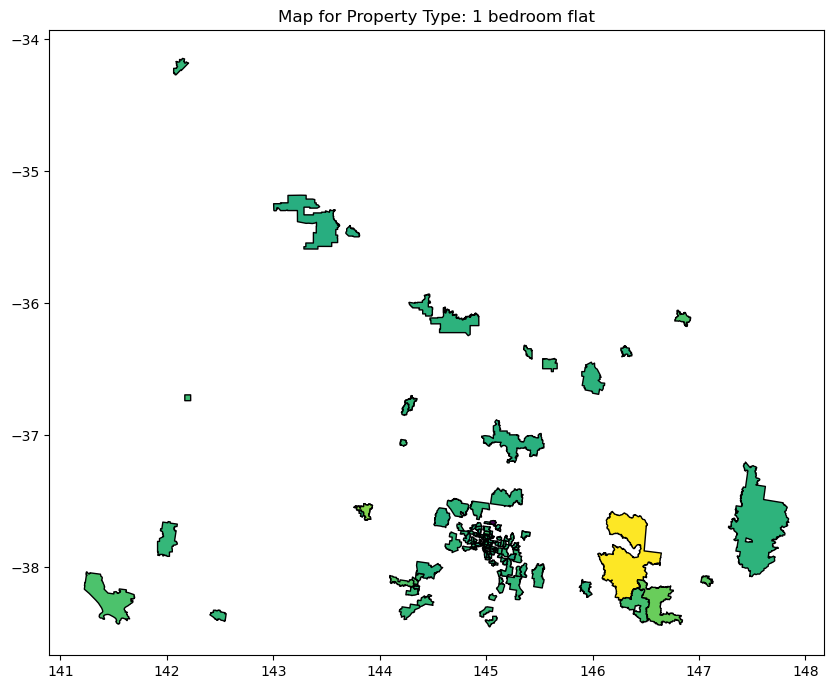

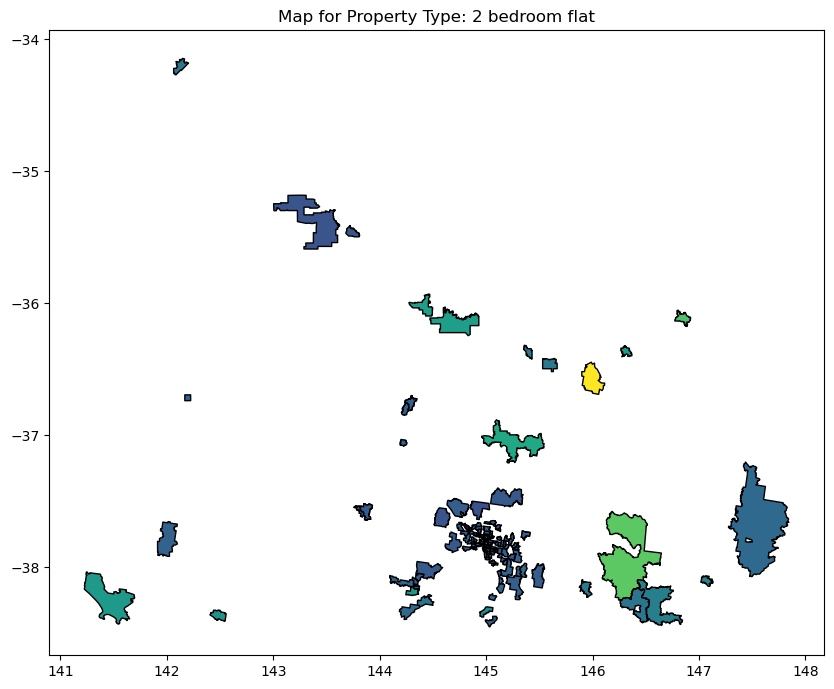

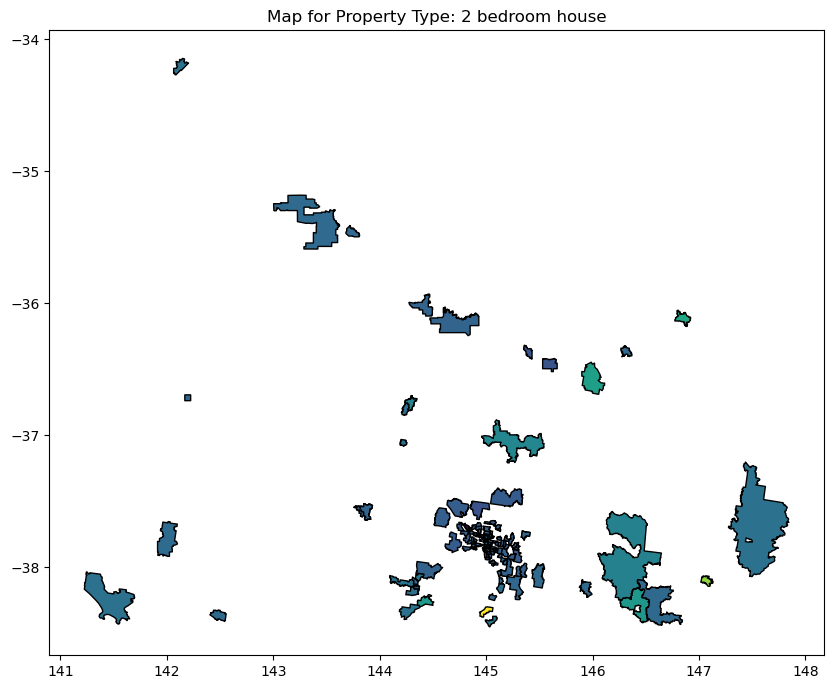

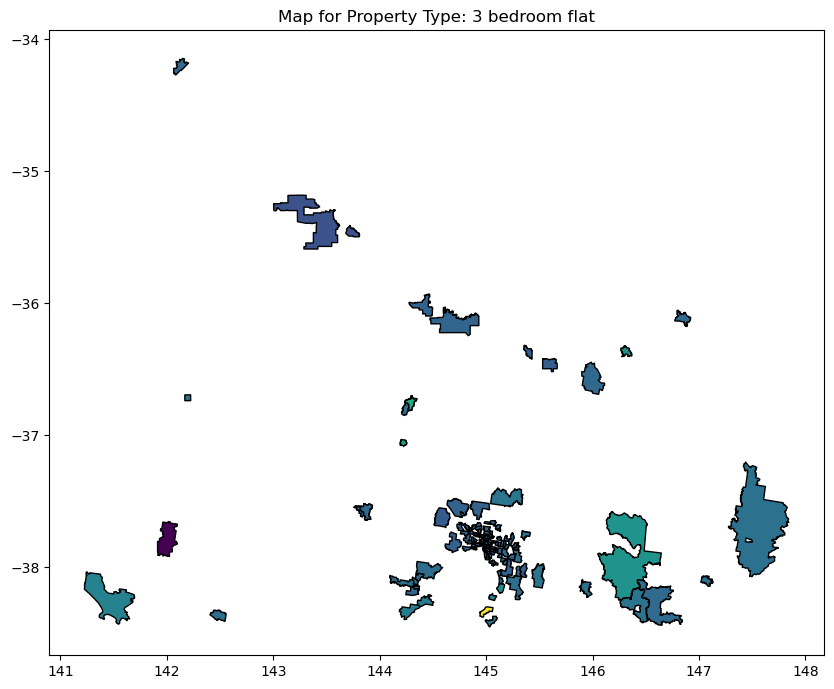

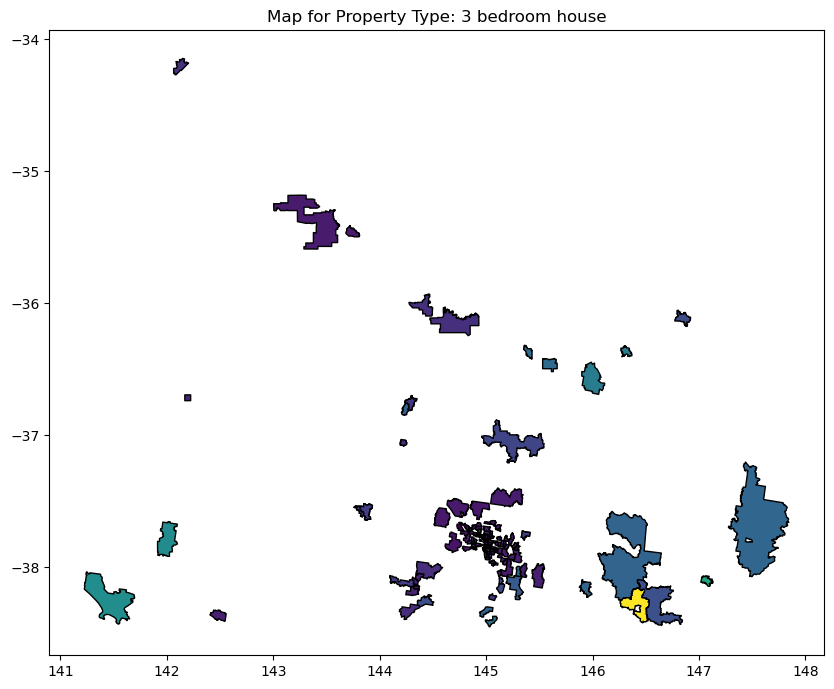

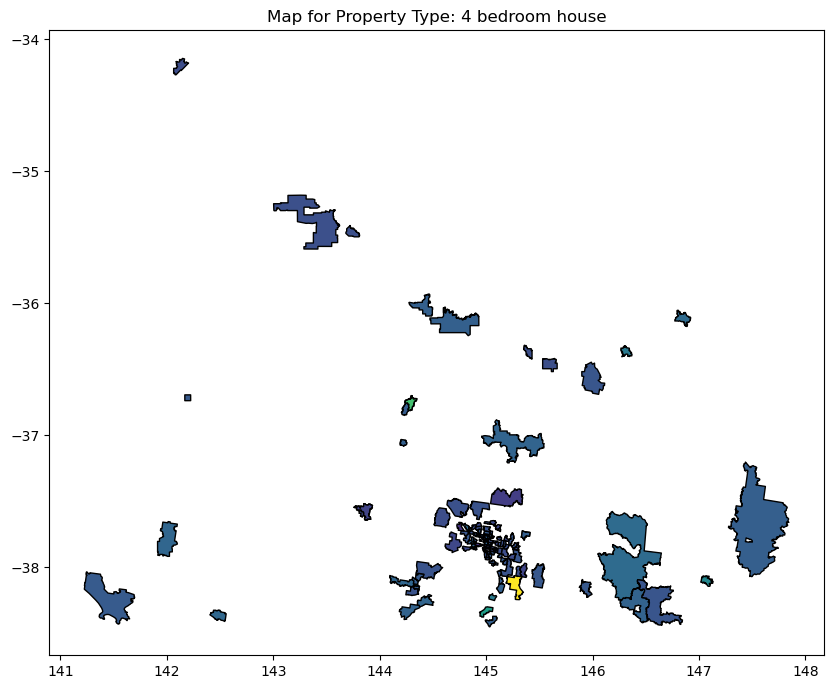

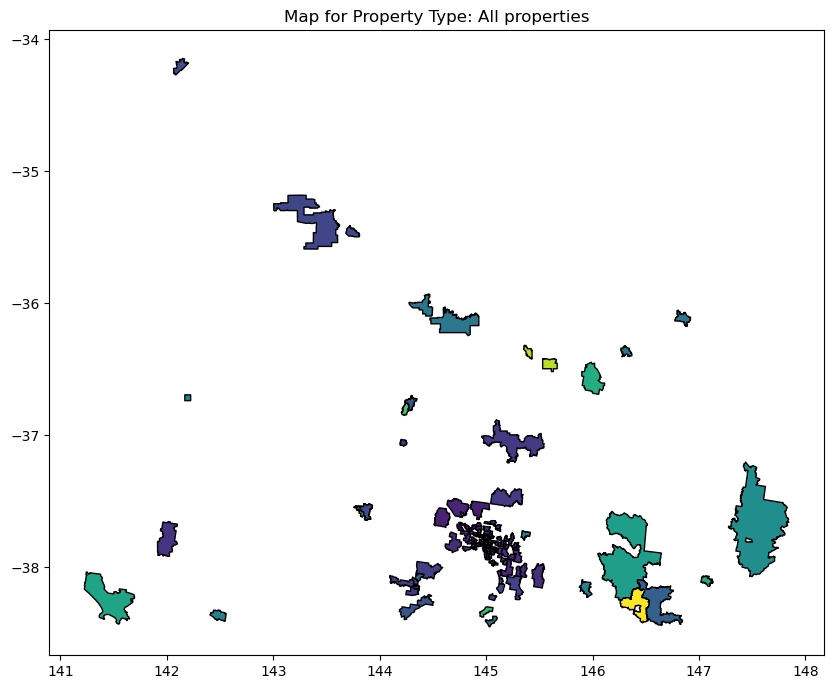

In [188]:
# Group by PropertyType to plot different maps
my_geo_df = gpd.GeoDataFrame(merge_growth_df, geometry='geometry')
for property_type in my_geo_df['PropertyType'].unique():
    subset = my_geo_df[my_geo_df['PropertyType'] == property_type]

    # Plotting the map
    fig, ax = plt.subplots(figsize=(10, 10))
    subset.plot(ax=ax, column='GrowthRate', edgecolor='black')
    plt.title(f"Map for Property Type: {property_type}")
    plt.show()

In [189]:
# Regulate the Region column
merged_df['Normalized_Region'] = merged_df['Region'].apply(lambda x: ' '.join(sorted(x.lower().replace('-', ' ').strip().split())))
merged_df

Unnamed: 0                  Region  \
0                0         Inner Melbourne   
1                1         Inner Melbourne   
2                2         Inner Melbourne   
3                3         Inner Melbourne   
4                4         Inner Melbourne   
...            ...                     ...   
103504      103504  Other Regional Centres   
103505      103505  Other Regional Centres   
103506      103506  Other Regional Centres   
103507      103507  Other Regional Centres   
103508      103508  Other Regional Centres   

                                       Suburb       Date    Count  Median  \
0       Albert Park-Middle Park-West St Kilda 2000-03-01    352.0   165.0   
1                                    Armadale 2000-03-01    210.0   150.0   
2                               Carlton North 2000-03-01     87.0   150.0   
3                           Carlton-Parkville 2000-03-01    303.0   165.0   
4                             CBD-St Kilda Rd 2000-03-01    755.0   250.0   
...                                       ...        ...      ...     ...   
103504                            Wanagaratta 2023-03-01    518.0   380.0   
103505                               Warragul 2023-03-01    497.0   440.0   
103506                            Warrnambool 2023-03-01    867.0   420.0   
103507                                Wodonga 2023-03-01   1173.0   410.0   
103508                            Group Total 2023-03-01  11944.0   390.0   

          PropertyType  Postcode       Normalized_Region  
0       1 bedroom flat    3182.0         inner melbourne  
1       1 bedroom flat    3143.0         inner melbourne  
2       1 bedroom flat    3054.0         inner melbourne  
3       1 bedroom flat    3010.0         inner melbourne  
4       1 bedroom flat    3004.0         inner melbourne  
...                ...       ...                     ...  
103504  All properties    3677.0  centres other regional  
103505  All properties    3820.0  centres other regional  
103506  All properties    3280.0  centres other regional  
103507  All properties    3690.0  centres other regional  
103508  All properties       NaN  centres other regional  

[103509 rows x 9 columns]

In [190]:
# Read population data files
population_df = pd.read_excel('/Users/chencheng/Downloads/32180DS0003_2001-23.xlsx', sheet_name='Table 1', header=[5])

# Remove the missing value
population_df.dropna(inplace=True)

# Normalize the 'SA4 name' column
population_df['Normalized_Region'] = population_df['SA4 name'].apply(lambda x: ' '.join(sorted(x.lower().replace('-', ' ').strip().split())))

In [191]:
# Extract column names and convert them into lists
pop_names = population_df.columns.tolist()

# Transform the data
population_df = population_df.melt(id_vars=pop_names[:8]+[pop_names[-1]], value_vars=pop_names[8:], var_name='Date', value_name='Population')

# Convert the date column to date format
population_df['Date'] = pd.to_datetime(population_df['Date'], format='%Y')
population_df

GCCSA code                    GCCSA name  SA4 code  \
0          1RNSW                   Rest of NSW     101.0   
1          1RNSW                   Rest of NSW     101.0   
2          1RNSW                   Rest of NSW     101.0   
3          1RNSW                   Rest of NSW     101.0   
4          1RNSW                   Rest of NSW     101.0   
...          ...                           ...       ...   
56437      8ACTE  Australian Capital Territory     801.0   
56438      9OTER             Other Territories     901.0   
56439      9OTER             Other Territories     901.0   
56440      9OTER             Other Territories     901.0   
56441      9OTER             Other Territories     901.0   

                           SA4 name  SA3 code                 SA3 name  \
0                    Capital Region   10102.0               Queanbeyan   
1                    Capital Region   10102.0               Queanbeyan   
2                    Capital Region   10102.0               Queanbeyan   
3                    Capital Region   10102.0               Queanbeyan   
4                    Capital Region   10102.0               Queanbeyan   
...                             ...       ...                      ...   
56437  Australian Capital Territory   80111.0        Uriarra - Namadgi   
56438             Other Territories   90101.0         Christmas Island   
56439             Other Territories   90102.0  Cocos (Keeling) Islands   
56440             Other Territories   90103.0               Jervis Bay   
56441             Other Territories   90104.0           Norfolk Island   

          SA2 code                         SA2 name  \
0      101021007.0                        Braidwood   
1      101021008.0                          Karabar   
2      101021009.0                       Queanbeyan   
3      101021010.0                Queanbeyan - East   
4      101021012.0  Queanbeyan West - Jerrabomberra   
...            ...                              ...   
56437  801111141.0                          Namadgi   
56438  901011001.0                 Christmas Island   
56439  901021002.0          Cocos (Keeling) Islands   
56440  901031003.0                       Jervis Bay   
56441  901041004.0                   Norfolk Island   

                  Normalized_Region       Date  Population  
0                    capital region 2001-01-01      2760.0  
1                    capital region 2001-01-01      9129.0  
2                    capital region 2001-01-01      9717.0  
3                    capital region 2001-01-01      3925.0  
4                    capital region 2001-01-01      9425.0  
...                             ...        ...         ...  
56437  australian capital territory 2023-01-01        67.0  
56438             other territories 2023-01-01      1823.0  
56439             other territories 2023-01-01       631.0  
56440             other territories 2023-01-01       307.0  
56441             other territories 2023-01-01      2209.0  

[56442 rows x 11 columns]

Use the name_mapping dictionary to replace the name of the Normalized_Region column in the merged_df data box to achieve the unity of the region name.

In [192]:
name_mapping = {
    'eastern melbourne north': 'east melbourne north',
    'eastern melbourne outer': 'east melbourne outer',
    'eastern melbourne south': 'east melbourne south',
    'melbourne north western': 'melbourne north west',
    'melbourne outer western': 'melbourne west',
    'eastern inner melbourne': 'east inner melbourne',
    'melbourne southern': 'inner melbourne south'
    # Add more mappings as needed
}

merged_df['Normalized_Region'] = merged_df['Normalized_Region'].replace(name_mapping)


In [193]:

region_names = merged_df['Normalized_Region'].unique()
region_pop = population_df[population_df['Normalized_Region'].isin(region_names)]

region_pop = region_pop[['Normalized_Region', 'Population', 'Date']].groupby(['Normalized_Region', 'Date']).sum()

region_pop

Population
Normalized_Region    Date                  
ballarat             2001-01-01    133961.0
                     2002-01-01    134805.0
                     2003-01-01    135729.0
                     2004-01-01    136262.0
                     2005-01-01    137070.0
...                                     ...
mornington peninsula 2019-01-01    310564.0
                     2020-01-01    312377.0
                     2021-01-01    311264.0
                     2022-01-01    310894.0
                     2023-01-01    313069.0

[276 rows x 1 columns]

Draw a line chart of the median rent in different areas that changes over time.

<AxesSubplot:xlabel='Date', ylabel='Median'>

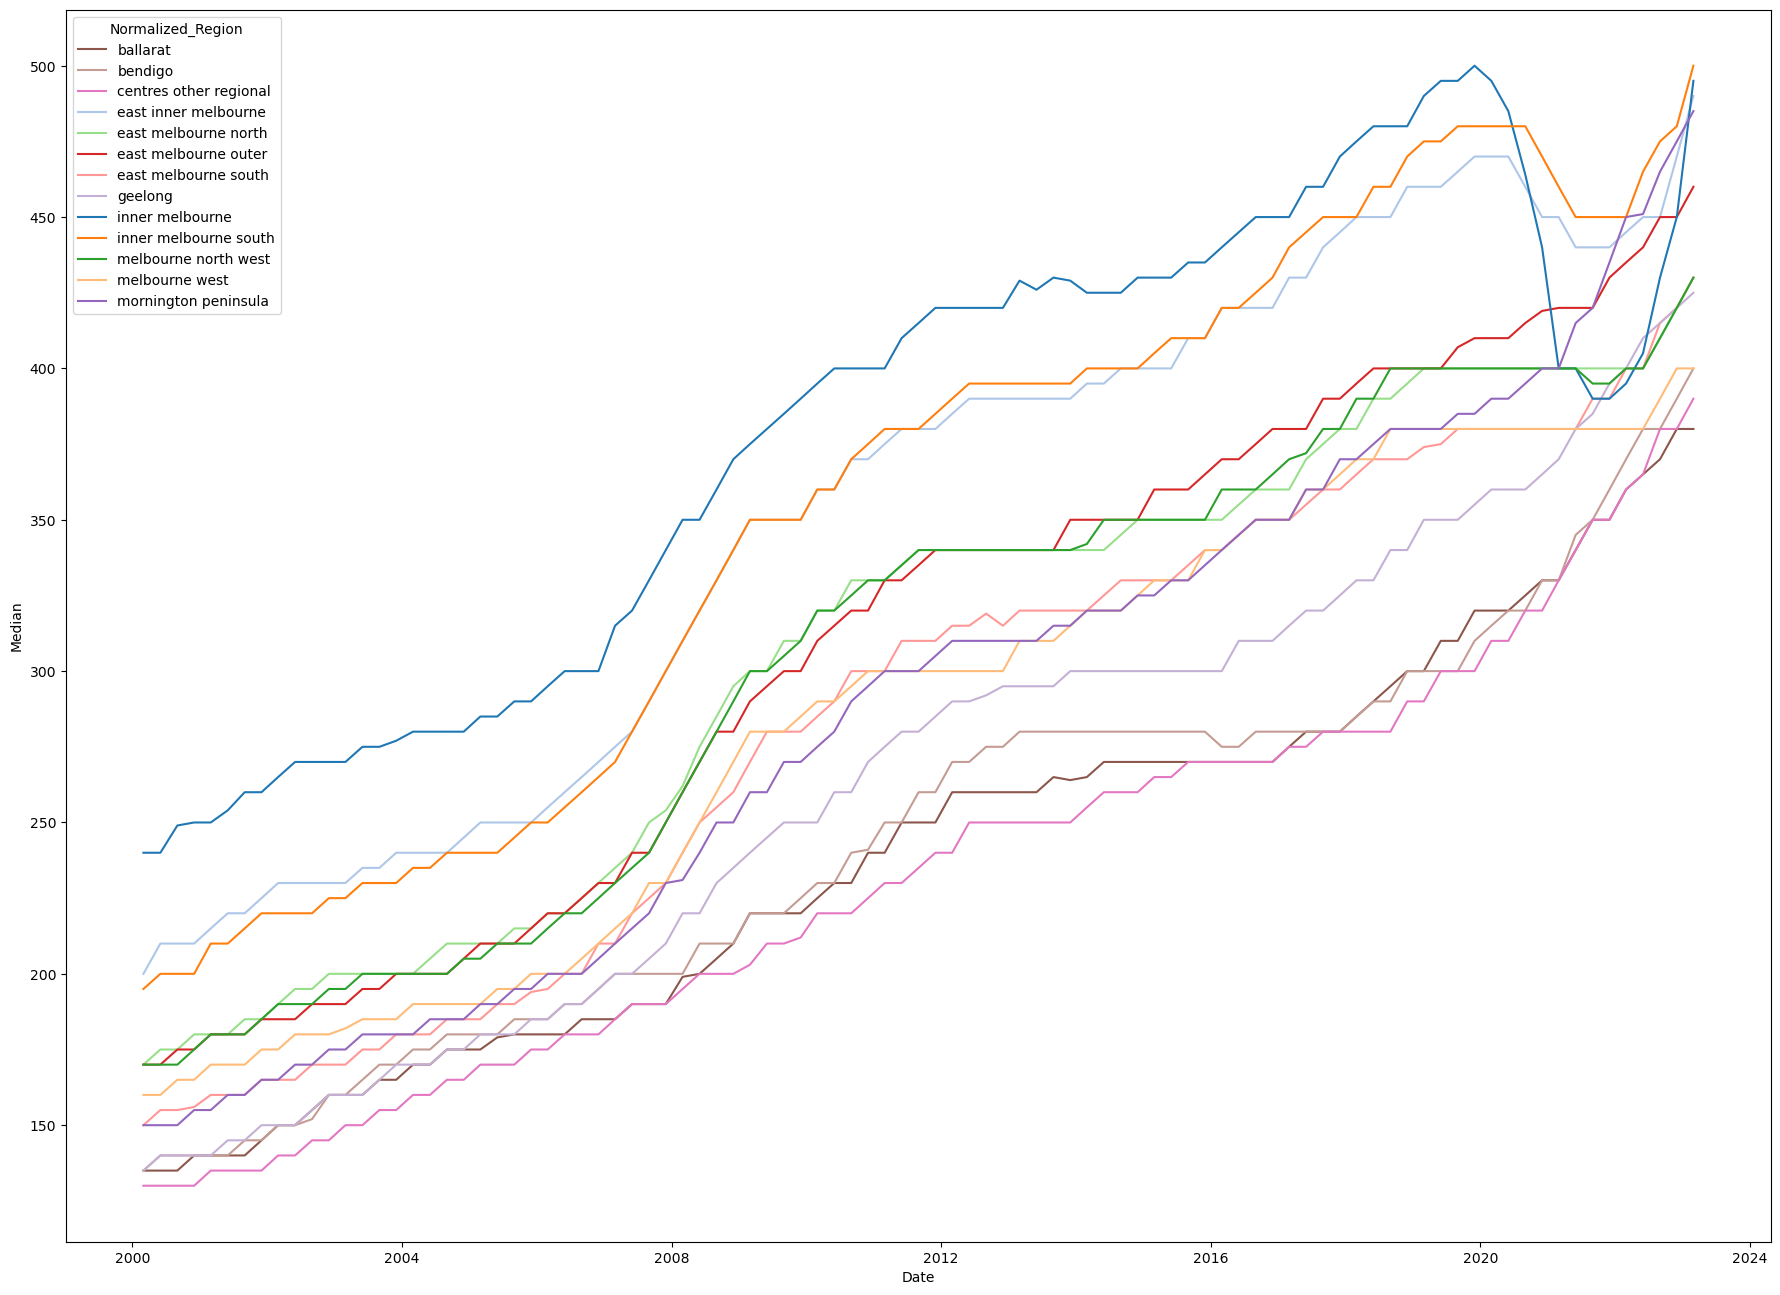

In [194]:
region_rent = merged_df[(merged_df['Suburb']=='Group Total') & 
                        (merged_df['PropertyType']=='All properties')]
                        
regions = region_rent['Normalized_Region'].unique()
palette = sns.color_palette('tab20', len(regions))
regions_sorted = sorted(regions)

sns.set_style("whitegrid")
plt.style.use("default")
region_palette = dict(zip(regions, palette))
plt.figure(figsize=(22,16))
sns.lineplot(data=region_rent, x='Date', y='Median', hue='Normalized_Region', 
             palette=region_palette, hue_order=regions_sorted)

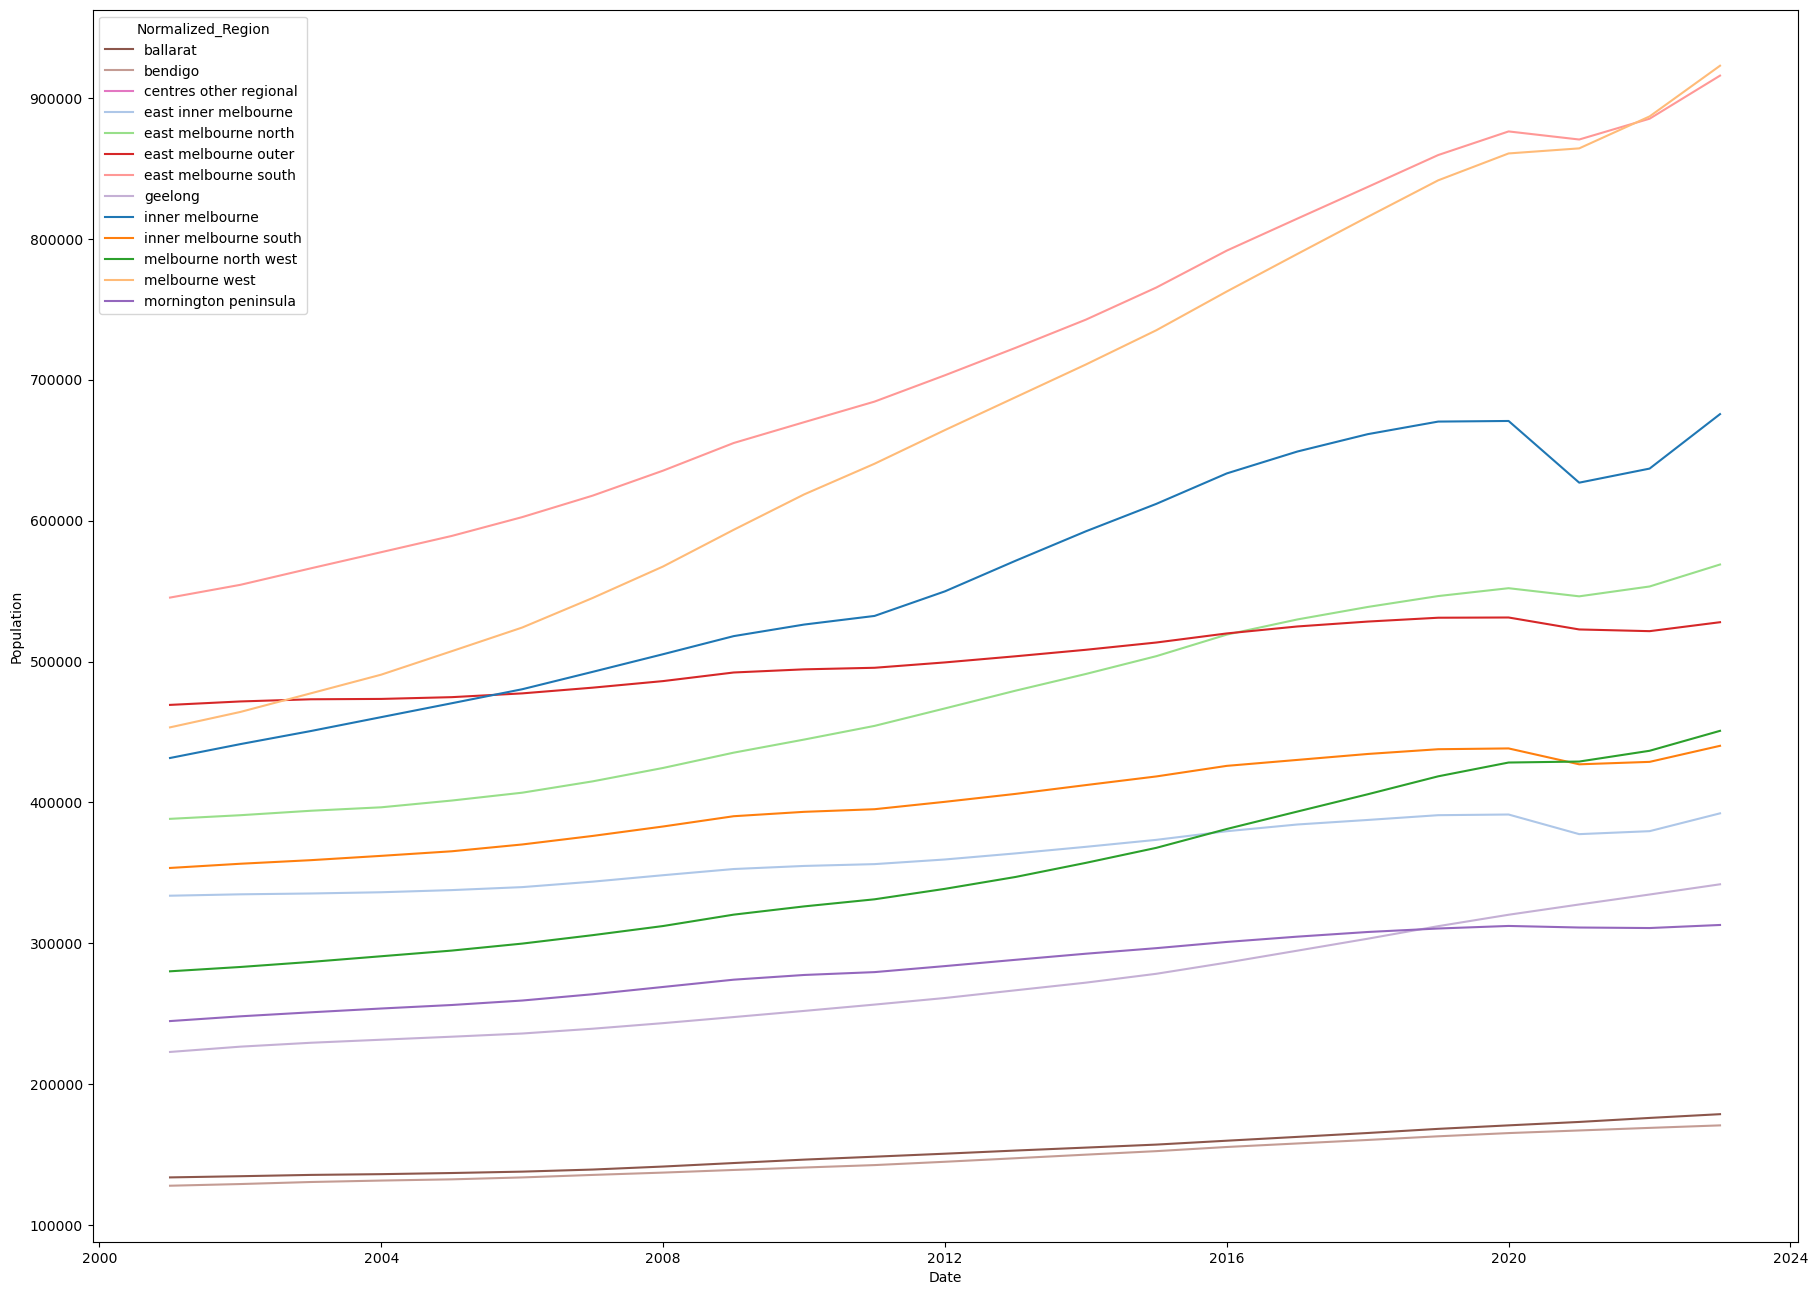

In [195]:
plt.figure(figsize=(22,16)) 
sns.lineplot(data=region_pop, x='Date', y='Population', hue='Normalized_Region', palette=region_palette, hue_order=regions_sorted)
plt.show()

In [196]:
# Reset the index
region_pop = region_pop.reset_index()

# Extract the year information
region_pop['Year'] = region_pop['Date'].dt.year
region_pop = region_pop.drop(columns='Date')

# Convert the date of the merged data box to the year
merged_df['Year'] = merged_df['Date'].dt.year

# Merge data boxes
merged_df = merged_df.merge(region_pop, left_on=['Normalized_Region', 'Year'], right_on=['Normalized_Region', 'Year'])

merged_df

Unnamed: 0           Region                                 Suburb  \
0             636  Inner Melbourne  Albert Park-Middle Park-West St Kilda   
1             637  Inner Melbourne                               Armadale   
2             638  Inner Melbourne                          Carlton North   
3             639  Inner Melbourne                      Carlton-Parkville   
4             640  Inner Melbourne                        CBD-St Kilda Rd   
...           ...              ...                                    ...   
85346      103482          Bendigo                                Bendigo   
85347      103483          Bendigo                Flora Hill-Bendigo East   
85348      103484          Bendigo            Golden Square-Kangaroo Flat   
85349      103485          Bendigo                          North Bendigo   
85350      103486          Bendigo                            Group Total   

            Date   Count  Median    PropertyType  Postcode Normalized_Region  \
0     2001-03-01   395.0   180.0  1 bedroom flat    3182.0   inner melbourne   
1     2001-03-01   206.0   160.0  1 bedroom flat    3143.0   inner melbourne   
2     2001-03-01    73.0   160.0  1 bedroom flat    3054.0   inner melbourne   
3     2001-03-01   360.0   190.0  1 bedroom flat    3010.0   inner melbourne   
4     2001-03-01  1145.0   255.0  1 bedroom flat    3004.0   inner melbourne   
...          ...     ...     ...             ...       ...               ...   
85346 2023-03-01   398.0   383.0  All properties    3550.0           bendigo   
85347 2023-03-01   827.0   390.0  All properties    3550.0           bendigo   
85348 2023-03-01   522.0   400.0  All properties    3555.0           bendigo   
85349 2023-03-01   879.0   400.0  All properties    3550.0           bendigo   
85350 2023-03-01  2626.0   400.0  All properties       NaN           bendigo   

       Year  Population  
0      2001    431549.0  
1      2001    431549.0  
2      2001    431549.0  
3      2001    431549.0  
4      2001    431549.0  
...     ...         ...  
85346  2023    170869.0  
85347  2023    170869.0  
85348  2023    170869.0  
85349  2023    170869.0  
85350  2023    170869.0  

[85351 rows x 11 columns]

In [197]:
# Read and process offense data
offense_df = pd.read_excel('/Users/chencheng/Downloads/Data_Tables_Property_Items_Visualisation_Year_Ending_June_2024.xlsx', sheet_name='Table 06')
offense_df.dropna(inplace=True)
offense_df

# Standardize Suburb name
offense_df['Normalized_Suburb'] = offense_df['Suburb/Town'].apply(lambda x: ' '.join(sorted(x.lower().replace('-', ' ').strip().split())))

# Standardize the Suburb name in merged_df
merged_df['Normalized_Suburb'] = merged_df['Suburb'].apply(lambda x: ' '.join(sorted(x.lower().replace('-', ' ').strip().split())))

# Merge data boxes
merged_df = merged_df.merge(offense_df, left_on=['Normalized_Suburb', 'Year'], right_on=['Normalized_Suburb', 'Year'])

# Display the merged data box
merged_df

Unnamed: 0           Region         Suburb       Date  Count  Median  \
0            9541  Inner Melbourne       Armadale 2015-03-01  181.0   310.0   
1            9700  Inner Melbourne       Armadale 2015-06-01  171.0   310.0   
2            9859  Inner Melbourne       Armadale 2015-09-01  163.0   310.0   
3           10018  Inner Melbourne       Armadale 2015-12-01  158.0   310.0   
4           24328  Inner Melbourne       Armadale 2015-03-01  317.0   400.0   
...           ...              ...            ...        ...    ...     ...   
16984       44337          Bendigo  North Bendigo 2023-03-01   44.0   420.0   
16985       59124          Bendigo  North Bendigo 2023-03-01   55.0   350.0   
16986       73911          Bendigo  North Bendigo 2023-03-01  395.0   400.0   
16987       88698          Bendigo  North Bendigo 2023-03-01  225.0   460.0   
16988      103485          Bendigo  North Bendigo 2023-03-01  879.0   400.0   

          PropertyType  Postcode_x Normalized_Region  Year  Population  \
0       1 bedroom flat      3143.0   inner melbourne  2015    611882.0   
1       1 bedroom flat      3143.0   inner melbourne  2015    611882.0   
2       1 bedroom flat      3143.0   inner melbourne  2015    611882.0   
3       1 bedroom flat      3143.0   inner melbourne  2015    611882.0   
4       2 bedroom flat      3143.0   inner melbourne  2015    611882.0   
...                ...         ...               ...   ...         ...   
16984   3 bedroom flat      3550.0           bendigo  2023    170869.0   
16985  2 bedroom house      3550.0           bendigo  2023    170869.0   
16986  3 bedroom house      3550.0           bendigo  2023    170869.0   
16987  4 bedroom house      3550.0           bendigo  2023    170869.0   
16988   All properties      3550.0           bendigo  2023    170869.0   

      Normalized_Suburb Year ending     Police Region Local Government Area  \
0              armadale        June  3 Southern Metro           Stonnington   
1              armadale        June  3 Southern Metro           Stonnington   
2              armadale        June  3 Southern Metro           Stonnington   
3              armadale        June  3 Southern Metro           Stonnington   
4              armadale        June  3 Southern Metro           Stonnington   
...                 ...         ...               ...                   ...   
16984     bendigo north        June         4 Western       Greater Bendigo   
16985     bendigo north        June         4 Western       Greater Bendigo   
16986     bendigo north        June         4 Western       Greater Bendigo   
16987     bendigo north        June         4 Western       Greater Bendigo   
16988     bendigo north        June         4 Western       Greater Bendigo   

      Postcode_y    Suburb/Town  Offence Count  
0           3143       Armadale             12  
1           3143       Armadale             12  
2           3143       Armadale             12  
3           3143       Armadale             12  
4           3143       Armadale             12  
...          ...            ...            ...  
16984       3550  North Bendigo             13  
16985       3550  North Bendigo             13  
16986       3550  North Bendigo             13  
16987       3550  North Bendigo             13  
16988       3550  North Bendigo             13  

[16989 rows x 18 columns]

In [198]:
good_sub = merged_df[merged_df['Year'] == 2023]

In [199]:
good_sub

Unnamed: 0           Region         Suburb       Date  Count  Median  \
16464       14629  Inner Melbourne       Armadale 2023-03-01  204.0   360.0   
16465       29416  Inner Melbourne       Armadale 2023-03-01  354.0   485.0   
16466       44203  Inner Melbourne       Armadale 2023-03-01   56.0   685.0   
16467       58990  Inner Melbourne       Armadale 2023-03-01   43.0   675.0   
16468       73777  Inner Melbourne       Armadale 2023-03-01   54.0   973.0   
...           ...              ...            ...        ...    ...     ...   
16984       44337          Bendigo  North Bendigo 2023-03-01   44.0   420.0   
16985       59124          Bendigo  North Bendigo 2023-03-01   55.0   350.0   
16986       73911          Bendigo  North Bendigo 2023-03-01  395.0   400.0   
16987       88698          Bendigo  North Bendigo 2023-03-01  225.0   460.0   
16988      103485          Bendigo  North Bendigo 2023-03-01  879.0   400.0   

          PropertyType  Postcode_x Normalized_Region  Year  Population  \
16464   1 bedroom flat      3143.0   inner melbourne  2023    675551.0   
16465   2 bedroom flat      3143.0   inner melbourne  2023    675551.0   
16466   3 bedroom flat      3143.0   inner melbourne  2023    675551.0   
16467  2 bedroom house      3143.0   inner melbourne  2023    675551.0   
16468  3 bedroom house      3143.0   inner melbourne  2023    675551.0   
...                ...         ...               ...   ...         ...   
16984   3 bedroom flat      3550.0           bendigo  2023    170869.0   
16985  2 bedroom house      3550.0           bendigo  2023    170869.0   
16986  3 bedroom house      3550.0           bendigo  2023    170869.0   
16987  4 bedroom house      3550.0           bendigo  2023    170869.0   
16988   All properties      3550.0           bendigo  2023    170869.0   

      Normalized_Suburb Year ending     Police Region Local Government Area  \
16464          armadale        June  3 Southern Metro           Stonnington   
16465          armadale        June  3 Southern Metro           Stonnington   
16466          armadale        June  3 Southern Metro           Stonnington   
16467          armadale        June  3 Southern Metro           Stonnington   
16468          armadale        June  3 Southern Metro           Stonnington   
...                 ...         ...               ...                   ...   
16984     bendigo north        June         4 Western       Greater Bendigo   
16985     bendigo north        June         4 Western       Greater Bendigo   
16986     bendigo north        June         4 Western       Greater Bendigo   
16987     bendigo north        June         4 Western       Greater Bendigo   
16988     bendigo north        June         4 Western       Greater Bendigo   

      Postcode_y    Suburb/Town  Offence Count  
16464       3143       Armadale             25  
16465       3143       Armadale             25  
16466       3143       Armadale             25  
16467       3143       Armadale             25  
16468       3143       Armadale             25  
...          ...            ...            ...  
16984       3550  North Bendigo             13  
16985       3550  North Bendigo             13  
16986       3550  North Bendigo             13  
16987       3550  North Bendigo             13  
16988       3550  North Bendigo             13  

[525 rows x 18 columns]

In [200]:
edu_df = pd.read_csv('/Users/chencheng/Downloads/finalised_rental.csv')
edu_df['Postcode'] = edu_df['address'].str[-4:]
edu_df

Unnamed: 0        id        rent  \
0              0  17205306  550.000000   
1              1  17205042  700.000000   
2              2  17204896  480.000000   
3              3  17203170  490.000000   
4              4  17202789  602.445842   
...          ...       ...         ...   
7394        7394  17124541  530.000000   
7395        7395  16459587  700.000000   
7396        7396  16475903  550.000000   
7397        7397  17093192  450.000000   
7398        7398  16893939  410.000000   

                                          address  suburb  bedroom  bathroom  \
0              3 Times Square POINT COOK,VIC 3030    3030      3.0       2.0   
1            97 Seaview Ave SAFETY BEACH,VIC 3936    3936      4.0       3.0   
2             13 CUMMINGS STREET WODONGA,VIC 3690    3690      3.0       1.0   
3             8 John Street GEELONG WEST,VIC 3218    3218      2.0       1.0   
4                7 Auburn Grove ARMADALE,VIC 3143    3143      4.0       1.0   
...                                           ...     ...      ...       ...   
7394  3/24 Griffen Street HAMLYN HEIGHTS,VIC 3215    3215      3.0       2.0   
7395         4/3 Donald Street BRUNSWICK,VIC 3056    3056      3.0       2.0   
7396        2/50 Lane Crescent RESERVOIR,VIC 3073    3073      2.0       1.0   
7397          7 Cilantro Street KALKALLO,VIC 3064    3064      3.0       2.0   
7398       5/150 Holdsworth Road BENDIGO,VIC 3550    3550      2.0       1.0   

      parking propertyType        land  ...  Owner  Renter  Family  Single  \
0         3.0        House  537.350649  ...     77      23      68      32   
1         1.0        House  537.350649  ...     61      39      63      37   
2         2.0        House  537.350649  ...     41      59      39      61   
3         1.0        House  537.350649  ...     58      42      51      49   
4         1.0        House  615.000000  ...     50      50      53      47   
...       ...          ...         ...  ...    ...     ...     ...     ...   
7394      2.0    Townhouse  537.350649  ...     71      29      54      46   
7395      1.0    Townhouse  537.350649  ...     45      55      40      60   
7396      1.0    Townhouse  537.350649  ...     44      56      40      60   
7397      1.0    Townhouse  537.350649  ...     75      25      56      44   
7398      1.0    Townhouse  537.350649  ...     56      44      45      55   

                                       propertyFeatures  \
0     Built in wardrobes,Dishwasher,Ensuite(s),Outdo...   
1                                          Pets Allowed   
2     Fully fenced,Secure Parking,Built in wardrobes...   
3     Split System Air Con,Outdoor Entertainment Are...   
4     Floorboards,Built in wardrobes,Dishwasher,Bath...   
...                                                 ...   
7394               Secure Parking*,Heating*,Dishwasher*   
7395  Floorboards,Built in wardrobes,Dishwasher,Duct...   
7396  Secure Parking*,Alarm System,Built in wardrobe...   
7397             Air conditioning*,Heating*,Dishwasher*   
7398   Built in wardrobes*,Heating*,Dishwasher*,Laundry   

                                            description  educationIndex  \
0     Parkside Living in Picturesque Sanctuary Lakes...        3.384399   
1     Coastal Living AwaitsEmbrace the beachside lif...        1.130325   
2     MOMENTS FROM CBDHaving been lovingly cared for...        3.521565   
3     COTTAGE CHARM ON LARGE BLOCKThis charming peri...        3.653881   
4     Victorian Beauty on a Quiet Grove, in Prme Loc...        3.806222   
...                                                 ...             ...   
7394  Recently built  luxury and location.Located in...        3.674811   
7395  FANTASTIC 3 BED TOWNHOUSE IN BRUNSWICKGreat lo...        3.674587   
7396  DOUBLE STOREY BEAUTY!This stunning 2 bedroom t...        3.649494   
7397  Exceptional Living Awaits at 7 Cilantro St, Ka...        3.458215   
7398  Brand New Townhouse in North BendigoThis brand...        3.4904

In [201]:
edu_df = edu_df[['Postcode', 'educationIndex', 'transportIndex','lifeIndex']].groupby('Postcode').mean().reset_index()

In [202]:
print(good_sub.columns)

print(edu_df.columns)

Index(['Unnamed: 0', 'Region', 'Suburb', 'Date', 'Count', 'Median',
       'PropertyType', 'Postcode_x', 'Normalized_Region', 'Year', 'Population',
       'Normalized_Suburb', 'Year ending', 'Police Region',
       'Local Government Area', 'Postcode_y', 'Suburb/Town', 'Offence Count'],
      dtype='object')
Index(['Postcode', 'educationIndex', 'transportIndex', 'lifeIndex'], dtype='object')


In [203]:
good_sub = good_sub.merge(edu_df, how='left', left_on='Postcode_y', right_on='Postcode')
good_sub.dropna(inplace=True)

In [204]:
good_sub = good_sub[~((good_sub['Suburb'] == 'Carlton North') & (good_sub['Local Government Area'] == 'Yarra'))]
good_sub

Unnamed: 0           Region         Suburb       Date  Count  Median  \
0         14629  Inner Melbourne       Armadale 2023-03-01  204.0   360.0   
1         29416  Inner Melbourne       Armadale 2023-03-01  354.0   485.0   
2         44203  Inner Melbourne       Armadale 2023-03-01   56.0   685.0   
3         58990  Inner Melbourne       Armadale 2023-03-01   43.0   675.0   
4         73777  Inner Melbourne       Armadale 2023-03-01   54.0   973.0   
..          ...              ...            ...        ...    ...     ...   
520       44337          Bendigo  North Bendigo 2023-03-01   44.0   420.0   
521       59124          Bendigo  North Bendigo 2023-03-01   55.0   350.0   
522       73911          Bendigo  North Bendigo 2023-03-01  395.0   400.0   
523       88698          Bendigo  North Bendigo 2023-03-01  225.0   460.0   
524      103485          Bendigo  North Bendigo 2023-03-01  879.0   400.0   

        PropertyType  Postcode_x Normalized_Region  Year  ...  Year ending  \
0     1 bedroom flat      3143.0   inner melbourne  2023  ...         June   
1     2 bedroom flat      3143.0   inner melbourne  2023  ...         June   
2     3 bedroom flat      3143.0   inner melbourne  2023  ...         June   
3    2 bedroom house      3143.0   inner melbourne  2023  ...         June   
4    3 bedroom house      3143.0   inner melbourne  2023  ...         June   
..               ...         ...               ...   ...  ...          ...   
520   3 bedroom flat      3550.0           bendigo  2023  ...         June   
521  2 bedroom house      3550.0           bendigo  2023  ...         June   
522  3 bedroom house      3550.0           bendigo  2023  ...         June   
523  4 bedroom house      3550.0           bendigo  2023  ...         June   
524   All properties      3550.0           bendigo  2023  ...         June   

        Police Region Local Government Area Postcode_y    Suburb/Town  \
0    3 Southern Metro           Stonnington       3143       Armadale   
1    3 Southern Metro           Stonnington       3143       Armadale   
2    3 Southern Metro           Stonnington       3143       Armadale   
3    3 Southern Metro           Stonnington       3143       Armadale   
4    3 Southern Metro           Stonnington       3143       Armadale   
..                ...                   ...        ...            ...   
520         4 Western       Greater Bendigo       3550  North Bendigo   
521         4 Western       Greater Bendigo       3550  North Bendigo   
522         4 Western       Greater Bendigo       3550  North Bendigo   
523         4 Western       Greater Bendigo       3550  North Bendigo   
524         4 Western       Greater Bendigo       3550  North Bendigo   

    Offence Count Postcode  educationIndex transportIndex  lifeIndex  
0              25     3143        3.833631       4.208900   3.496733  
1              25     3143        3.833631       4.208900   3.496733  
2              25     3143        3.833631       4.208900   3.496733  
3              25     3143        3.833631       4.208900   3.496733  
4              25     3143        3.833631       4.208900   3.496733  
..            ...      ...             ...            ...        ...  
520            13     3550        3.551753       4.214874   2.830190  
521            13     3550        3.551753       4.214874   2.830190  
522            13     3550        3.551753       4.214874   2.830190  
523            13     3550        3.551753       4.214874   2.830190  
524            13     3550        3.551753       4.214874   2.830190  

[507 rows x 22 columns]

In [205]:
growth_df

GrowthRate              Region                  Suburb     PropertyType
0      32.913570            Ballarat                Ballarat   1 bedroom flat
1      14.174799            Ballarat                Ballarat   2 bedroom flat
2      13.196987            Ballarat                Ballarat  2 bedroom house
3      12.129023            Ballarat                Ballarat   3 bedroom flat
4      13.497911            Ballarat                Ballarat  3 bedroom house
...          ...                 ...                     ...              ...
1108   12.940505  Southern Melbourne  Murrumbeena-Hughesdale  2 bedroom house
1109   12.485836  Southern Melbourne  Murrumbeena-Hughesdale   3 bedroom flat
1110   13.012315  Southern Melbourne  Murrumbeena-Hughesdale  3 bedroom house
1111   13.918807  Southern Melbourne  Murrumbeena-Hughesdale  4 bedroom house
1112   14.646384  Southern Melbourne  Murrumbeena-Hughesdale   All properties

[1113 rows x 4 columns]

In [206]:
good_sub = good_sub.merge(growth_df[['GrowthRate', 'Suburb', 'PropertyType', 'Region']], 
                          how='left', 
                          left_on=['Suburb', 'PropertyType', 'Region'], 
                          right_on=['Suburb', 'PropertyType', 'Region'])

In [207]:
good_sub

Unnamed: 0           Region         Suburb       Date  Count  Median  \
0         14629  Inner Melbourne       Armadale 2023-03-01  204.0   360.0   
1         29416  Inner Melbourne       Armadale 2023-03-01  354.0   485.0   
2         44203  Inner Melbourne       Armadale 2023-03-01   56.0   685.0   
3         58990  Inner Melbourne       Armadale 2023-03-01   43.0   675.0   
4         73777  Inner Melbourne       Armadale 2023-03-01   54.0   973.0   
..          ...              ...            ...        ...    ...     ...   
502       44337          Bendigo  North Bendigo 2023-03-01   44.0   420.0   
503       59124          Bendigo  North Bendigo 2023-03-01   55.0   350.0   
504       73911          Bendigo  North Bendigo 2023-03-01  395.0   400.0   
505       88698          Bendigo  North Bendigo 2023-03-01  225.0   460.0   
506      103485          Bendigo  North Bendigo 2023-03-01  879.0   400.0   

        PropertyType  Postcode_x Normalized_Region  Year  ...  \
0     1 bedroom flat      3143.0   inner melbourne  2023  ...   
1     2 bedroom flat      3143.0   inner melbourne  2023  ...   
2     3 bedroom flat      3143.0   inner melbourne  2023  ...   
3    2 bedroom house      3143.0   inner melbourne  2023  ...   
4    3 bedroom house      3143.0   inner melbourne  2023  ...   
..               ...         ...               ...   ...  ...   
502   3 bedroom flat      3550.0           bendigo  2023  ...   
503  2 bedroom house      3550.0           bendigo  2023  ...   
504  3 bedroom house      3550.0           bendigo  2023  ...   
505  4 bedroom house      3550.0           bendigo  2023  ...   
506   All properties      3550.0           bendigo  2023  ...   

        Police Region Local Government Area Postcode_y    Suburb/Town  \
0    3 Southern Metro           Stonnington       3143       Armadale   
1    3 Southern Metro           Stonnington       3143       Armadale   
2    3 Southern Metro           Stonnington       3143       Armadale   
3    3 Southern Metro           Stonnington       3143       Armadale   
4    3 Southern Metro           Stonnington       3143       Armadale   
..                ...                   ...        ...            ...   
502         4 Western       Greater Bendigo       3550  North Bendigo   
503         4 Western       Greater Bendigo       3550  North Bendigo   
504         4 Western       Greater Bendigo       3550  North Bendigo   
505         4 Western       Greater Bendigo       3550  North Bendigo   
506         4 Western       Greater Bendigo       3550  North Bendigo   

    Offence Count Postcode educationIndex  transportIndex lifeIndex  \
0              25     3143       3.833631        4.208900  3.496733   
1              25     3143       3.833631        4.208900  3.496733   
2              25     3143       3.833631        4.208900  3.496733   
3              25     3143       3.833631        4.208900  3.496733   
4              25     3143       3.833631        4.208900  3.496733   
..            ...      ...            ...             ...       ...   
502            13     3550       3.551753        4.214874  2.830190   
503            13     3550       3.551753        4.214874  2.830190   
504            13     3550       3.551753        4.214874  2.830190   
505            13     3550       3.551753        4.214874  2.830190   
506            13     3550       3.551753        4.214874  2.830190   

     GrowthRate  
0     13.391287  
1     13.347784  
2     11.991807  
3     12.440231  
4     13.538225  
..          ...  
502   23.338734  
503   18.401361  
504   17.236658  
505   28.587459  
506   17.250216  

[507 rows x 23 columns]

In [208]:
result_df = good_sub[['Region', 'Suburb', 'Postcode', 'Population', 'PropertyType', 'Count', 'Median', 'Offence Count', 'educationIndex', 'GrowthRate', 'transportIndex','lifeIndex']]

In [209]:
print(result_df.columns)

Index(['Region', 'Suburb', 'Postcode', 'Population', 'PropertyType', 'Count',
       'Median', 'Offence Count', 'educationIndex', 'GrowthRate',
       'transportIndex', 'lifeIndex'],
      dtype='object')


In [210]:
gdf['POA_CODE21'] = gdf['POA_CODE21'].astype('int')

In [211]:
# Make sure that the Postcode column is a string type
result_df['Postcode'] = result_df['Postcode'].astype(str)

# Make sure that the POA_CODE21 column is also a string type
gdf['POA_CODE21'] = gdf['POA_CODE21'].astype(str)

# Carry out the merge operation
marge_result = result_df.merge(gdf, how='left', left_on='Postcode', right_on='POA_CODE21')

marge_result

Region         Suburb Postcode  Population     PropertyType  \
0    Inner Melbourne       Armadale     3143    675551.0   1 bedroom flat   
1    Inner Melbourne       Armadale     3143    675551.0   2 bedroom flat   
2    Inner Melbourne       Armadale     3143    675551.0   3 bedroom flat   
3    Inner Melbourne       Armadale     3143    675551.0  2 bedroom house   
4    Inner Melbourne       Armadale     3143    675551.0  3 bedroom house   
..               ...            ...      ...         ...              ...   
502          Bendigo  North Bendigo     3550    170869.0   3 bedroom flat   
503          Bendigo  North Bendigo     3550    170869.0  2 bedroom house   
504          Bendigo  North Bendigo     3550    170869.0  3 bedroom house   
505          Bendigo  North Bendigo     3550    170869.0  4 bedroom house   
506          Bendigo  North Bendigo     3550    170869.0   All properties   

     Count  Median  Offence Count  educationIndex  GrowthRate  ...  \
0    204.0   360.0             25        3.833631   13.391287  ...   
1    354.0   485.0             25        3.833631   13.347784  ...   
2     56.0   685.0             25        3.833631   11.991807  ...   
3     43.0   675.0             25        3.833631   12.440231  ...   
4     54.0   973.0             25        3.833631   13.538225  ...   
..     ...     ...            ...             ...         ...  ...   
502   44.0   420.0             13        3.551753   23.338734  ...   
503   55.0   350.0             13        3.551753   18.401361  ...   
504  395.0   400.0             13        3.551753   17.236658  ...   
505  225.0   460.0             13        3.551753   28.587459  ...   
506  879.0   400.0             13        3.551753   17.250216  ...   

     AUS_CODE21  AUS_NAME21 AREASQKM21  \
0           AUS   Australia     2.1647   
1           AUS   Australia     2.1647   
2           AUS   Australia     2.1647   
3           AUS   Australia     2.1647   
4           AUS   Australia     2.1647   
..          ...         ...        ...   
502         AUS   Australia    52.7325   
503         AUS   Australia    52.7325   
504         AUS   Australia    52.7325   
505         AUS   Australia    52.7325   
506         AUS   Australia    52.7325   

                                            LOCI_URI21 SHAPE_Leng SHAPE_Area  \
0    http://linked.data.gov.au/dataset/asgsed3/POA/...   0.076364   0.000222   
1    http://linked.data.gov.au/dataset/asgsed3/POA/...   0.076364   0.000222   
2    http://linked.data.gov.au/dataset/asgsed3/POA/...   0.076364   0.000222   
3    http://linked.data.gov.au/dataset/asgsed3/POA/...   0.076364   0.000222   
4    http://linked.data.gov.au/dataset/asgsed3/POA/...   0.076364   0.000222   
..                                                 ...        ...        ...   
502  http://linked.data.gov.au/dataset/asgsed3/POA/...   0.504182   0.005322   
503  http://linked.data.gov.au/dataset/asgsed3/POA/...   0.504182   0.005322   
504  http://linked.data.gov.au/dataset/asgsed3/POA/...   0.504182   0.005322   
505  http://linked.data.gov.au/dataset/asgsed3/POA/...   0.504182   0.005322   
506  http://linked.data.gov.au/dataset/asgsed3/POA/...   0.504182   0.005322   

                                              geometry      area  \
0    POLYGON ((145.02756 -37.86131, 145.02677 -37.8...  0.000217   
1    POLYGON ((145.02756 -37.86131, 145.02677 -37.8...  0.000217   
2    POLYGON ((145.02756 -37.86131, 145.02677 -37.8...  0.000217   
3    POLYGON ((145.02756 -37.86131, 145.02677 -37.8...  0.000217   
4    POLYGON ((145.02756 -37.86131, 145.02677 -37.8...  0.000217   
..                                                 ...       ...   
502  POLYGON ((144.32288 -36.77493, 144.31919 -36.7...  0.005347   
503  POLYGON ((144.32288 -36.77493, 144.31919 -36.7...  0.005347   
504  POLYGON ((144.32288 -36.77493, 144.31919 -36.7...  0.005347   
505  POLYGON ((144.32288 -36.77493, 144.31919 -36.7...  0.005347   
506  POLYGON ((144.32288 -36.77493

In [212]:
# 筛选 'PropertyType' 列中为 'All properties' 的行
marge_result = marge_result[result_df['PropertyType'] == 'All properties']

In [213]:
# 设置 POA_NAME21 作为索引
marge_result.set_index(['POA_NAME21'])

Region          Suburb Postcode  Population  \
POA_NAME21                                                         
3143        Inner Melbourne        Armadale     3143    675551.0   
3054        Inner Melbourne   Carlton North     3054    675551.0   
3008        Inner Melbourne       Docklands     3008    675551.0   
3002        Inner Melbourne  East Melbourne     3002    675551.0   
3183        Inner Melbourne   East St Kilda     3183    675551.0   
...                     ...             ...      ...         ...   
3212                Geelong            Lara     3212    341934.0   
3220                Geelong         Newtown     3220    341934.0   
3215                Geelong   North Geelong     3215    341934.0   
3550                Bendigo         Bendigo     3550    170869.0   
3550                Bendigo   North Bendigo     3550    170869.0   

              PropertyType   Count  Median  Offence Count  educationIndex  \
POA_NAME21                                                                  
3143        All properties   751.0   490.0             25        3.833631   
3054        All properties   490.0   620.0              2        3.676441   
3008        All properties  2726.0   550.0             32        3.763291   
3002        All properties   514.0   540.0             34        3.838594   
3183        All properties  1782.0   450.0              9        3.880897   
...                    ...     ...     ...            ...             ...   
3212        All properties   434.0   485.0             41        3.424894   
3220        All properties   285.0   450.0             23        3.659872   
3215        All properties   714.0   430.0             32        3.637773   
3550        All properties   398.0   383.0             40        3.551753   
3550        All properties   879.0   400.0             13        3.551753   

            GrowthRate  ...  AUS_CODE21  AUS_NAME21 AREASQKM21  \
POA_NAME21              ...                                      
3143         14.574287  ...         AUS   Australia     2.1647   
3054         12.881581  ...         AUS   Australia     2.3042   
3008         12.076469  ...         AUS   Australia     3.1480   
3002         12.693856  ...         AUS   Australia     1.8557   
3183         14.754303  ...         AUS   Australia     3.0288   
...                ...  ...         ...         ...        ...   
3212         15.567112  ...         AUS   Australia   189.5698   
3220         14.850748  ...         AUS   Australia    11.5417   
3215         16.172630  ...         AUS   Australia    17.0820   
3550         14.360560  ...         AUS   Australia    52.7325   
3550         17.250216  ...         AUS   Australia    52.7325   

                                                   LOCI_URI21 SHAPE_Leng  \
POA_NAME21                                                                 
3143        http://linked.data.gov.au/dataset/asgsed3/POA/...   0.076364   
3054        http://linked.data.gov.au/dataset/asgsed3/POA/...   0.061798   
3008        http://linked.data.gov.au/dataset/asgsed3/POA/...   0.091200   
3002        http://linked.data.gov.au/dataset/asgsed3/POA/...   0.059488   
3183        http://linked.data.gov.au/dataset/asgsed3/POA/...   0.078453   
...                                                       ...        ...   
3212        http://linked.data.gov.au/dataset/asgsed3/POA/...   0.943280   
3220        http://linked.data.gov.au/dataset/asgsed3/POA/...   0.220163   
3215        http://linked.data.gov.au/dataset/asgsed3/POA/...   0.221579   
3550        http://linked.data.gov.au/dataset/asgsed3/POA/...   0.504182   
3550        http://linked.data.gov.au/dataset/asgsed3/POA/...   0.504182   

            SHAPE_Area                                           geometry  \
POA_NAME21                                                                  
3143          0.000222  POLYGON ((145.02756 -37.86131, 145.02677 -37.8...   
3054          0.000236  POLYGON ((144.97276 -37.77956, 

In [214]:
marge_result.to_csv('/Users/chencheng/Downloads/Result1.csv')

In [215]:
result1 = gpd.GeoDataFrame(marge_result, geometry='geometry')

In [ ]:
# Normalize various indicators
result1['normalized_rent'] = (result1['Median'] - result1['Median'].min()) / (result1['Median'].max() - result1['Median'].min())
result1['normalized_offence_count'] = (result1['Offence Count'] - result1['Offence Count'].min()) / (result1['Offence Count'].max() - result1['Offence Count'].min())
result1['normalized_education_index'] = (result1['educationIndex'] - result1['educationIndex'].min()) / (result1['educationIndex'].max() - result1['educationIndex'].min())
result1['normalized_transport_index'] = (result1['transportIndex'] - result1['transportIndex'].min()) / (result1['transportIndex'].max() - result1['transportIndex'].min())
result1['normalized_population'] = (result1['Population'] - result1['Population'].min()) / (result1['Population'].max() - result1['Population'].min())
result1['normalized_lifeIndex'] = (result1['lifeIndex'] - result1['lifeIndex'].min()) / (result1['lifeIndex'].max() - result1['lifeIndex'].min())


result1['liveable_metric'] = (
    0.30 * (1 - result1['normalized_rent']) +  # Affordable (the lower the rent, the better)
    0.15 * (1 - result1['normalized_offence_count']) +  # Security (the lower the crime rate, the better)
    0.10 * result1['normalized_education_index'] +  # Education (the higher the level of education, the better)
    0.10 * result1['normalized_transport_index'] +  # Traffic accessibility (the more bus stops, the better)
    0.15 * result1['normalized_population'] +  # Higher population proportion
    0.10 * (1 - result1['GrowthRate']/100) +# Support a higher growth rate
    0.10 * result1['normalized_lifeIndex'] #The more parks there are, the better
)

Build a stochastic forest regression model to predict the impact of certain factors on livability indicators and draw a characteristic importance chart.

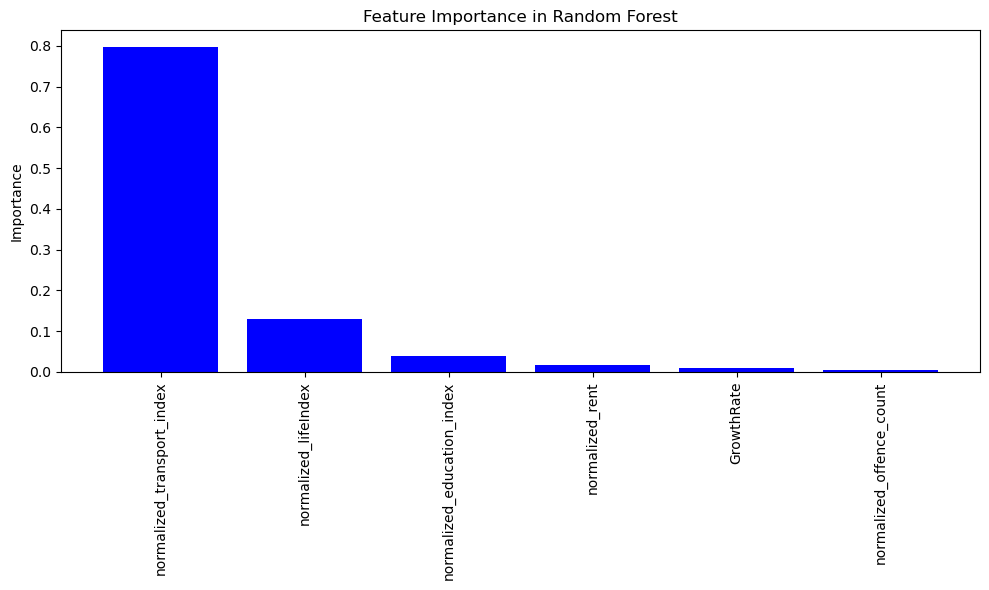

Mean Squared Error (MSE): 0.0030588528036537732


In [232]:
# Import the required library
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Read data
file_path = '/Users/chencheng/Downloads/Result1.csv'  # Replace with the actual file path
result1 = pd.read_csv(file_path)
# Column related to normalization
result1['normalized_rent'] = (result1['Median'] - result1['Median'].min()) / (result1['Median'].max() - result1['Median'].min())
result1['normalized_offence_count'] = (result1['Offence Count'] - result1['Offence Count'].min()) / (result1['Offence Count'].max() - result1['Offence Count'].min())
result1['normalized_education_index'] = (result1['educationIndex'] - result1['educationIndex'].min()) / (result1['educationIndex'].max() - result1['educationIndex'].min())
result1['normalized_transport_index'] = (result1['transportIndex'] - result1['transportIndex'].min()) / (result1['transportIndex'].max() - result1['transportIndex'].min())
result1['normalized_population'] = (result1['Population'] - result1['Population'].min()) / (result1['Population'].max() - result1['Population'].min())
result1['normalized_lifeIndex'] = (result1['lifeIndex'] - result1['lifeIndex'].min()) / (result1['lifeIndex'].max() - result1['lifeIndex'].min())
# Create a live-in_metric index
result1['liveable_metric'] = (
    0.30 * (1 - result1['normalized_rent']) +  
    0.15 * (1 - result1['normalized_offence_count']) +  
    0.15* result1['normalized_education_index'] +  
    0.15 * result1['normalized_transport_index'] +  
    0.10 * (1 - result1['GrowthRate'] / 100) +  
    0.15 * result1['normalized_lifeIndex']
)
# Define features and goals
features = ['normalized_rent', 'normalized_offence_count', 'normalized_education_index', 
            'normalized_transport_index', 'GrowthRate', 
            'normalized_lifeIndex']
X = result1[features]
y = result1['liveable_metric']

# Remove NaN data
X = X.dropna()
y = y.loc[X.index]

# Divide the training set and the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a random forest regression model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Fitting model
rf.fit(X_train, y_train)

# Predict and calculate the mean square error on the test set
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

# The importance of acquiring features
feature_importances = rf.feature_importances_

# Draw a feature importance diagram
plt.figure(figsize=(10, 6))
indices = np.argsort(feature_importances)[::-1]
plt.bar(range(len(features)), feature_importances[indices], color="b", align="center")
plt.xticks(range(len(features)), [features[i] for i in indices], rotation=90)
plt.title("Feature Importance in Random Forest")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()
# Output mean square error
print(f'Mean Squared Error (MSE): {mse}')

In [233]:

# Sort according to the calculated livability index to display the top 10 suburbs
best_suburbs = result1.sort_values(by='liveable_metric', ascending=False).head(10)

# Select the column that needs to be displayed
best_suburbs[['Region', 'Suburb', 'liveable_metric']]

Region         Suburb  liveable_metric
1           Inner Melbourne  Carlton North         0.900288
23  Inner Eastern Melbourne            Kew         0.871921
7           Inner Melbourne        Fitzroy         0.858491
6           Inner Melbourne         Elwood         0.836880
33       Southern Melbourne    Elsternwick         0.831706
4           Inner Melbourne  East St Kilda         0.822287
5           Inner Melbourne  East St Kilda         0.822287
27       Southern Melbourne  Brighton East         0.822107
42  Outer Western Melbourne   Williamstown         0.818606
0           Inner Melbourne       Armadale         0.809240

In [234]:
import geopandas as gpd
from shapely import wkt

result1['geometry'] = result1['geometry'].apply(wkt.loads)
my_geo_df = gpd.GeoDataFrame(result1, geometry='geometry')

# Set the index
my_geo_df.index = my_geo_df['POA_NAME21']

# Print information
my_geo_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 74 entries, 3143 to 3550
Data columns (total 32 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   Unnamed: 0                  74 non-null     int64   
 1   Region                      74 non-null     object  
 2   Suburb                      74 non-null     object  
 3   Postcode                    74 non-null     int64   
 4   Population                  74 non-null     float64 
 5   PropertyType                74 non-null     object  
 6   Count                       74 non-null     float64 
 7   Median                      74 non-null     float64 
 8   Offence Count               74 non-null     int64   
 9   educationIndex              74 non-null     float64 
 10  GrowthRate                  74 non-null     float64 
 11  transportIndex              74 non-null     float64 
 12  lifeIndex                   74 non-null     float64 
 13  POA_CODE2

In [235]:
my_geo_df.to_csv('/Users/chencheng/Downloads/my_geo_df.csv')

In [236]:
my_geo_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 74 entries, 3143 to 3550
Data columns (total 32 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   Unnamed: 0                  74 non-null     int64   
 1   Region                      74 non-null     object  
 2   Suburb                      74 non-null     object  
 3   Postcode                    74 non-null     int64   
 4   Population                  74 non-null     float64 
 5   PropertyType                74 non-null     object  
 6   Count                       74 non-null     float64 
 7   Median                      74 non-null     float64 
 8   Offence Count               74 non-null     int64   
 9   educationIndex              74 non-null     float64 
 10  GrowthRate                  74 non-null     float64 
 11  transportIndex              74 non-null     float64 
 12  lifeIndex                   74 non-null     float64 
 13  POA_CODE2

In [237]:
import plotly.express as px

# Draw a Mapbox map
fig = px.choropleth_mapbox(
    my_geo_df,                       
    geojson=my_geo_df.geometry,       
    locations=my_geo_df.index,         
    color="liveable_metric",          # Use 'liveable_metric' as the basis for color mapping
    opacity=0.6,                       # Set the transparency of the layer
    mapbox_style="carto-positron",     # Mapbox style
    zoom=6,                           # Zoom level
    center={"lat": -38, "lon": 145.75},# Set up the map center
    hover_name='Suburb',               # The name displayed when the mouse hovers
    color_continuous_scale=px.colors.diverging.RdBu  # Set up color mapping
)

# Show the map
fig.show()

In [ ]:
import plotly.express as px
# Draw a Mapbox map
fig = px.choropleth_mapbox(
    my_geo_df,                       
    geojson=my_geo_df.geometry,       
    locations=my_geo_df.index,         
    color="educationIndex",          # Use 'liveable_metric' as the basis for color mapping
    opacity=0.6,                       # Set the transparency of the layer
    mapbox_style="carto-positron",     # Mapbox Pattern
    zoom=6,                           # Zoom level
    center={"lat": -38, "lon": 145.75},# Set up the map center
    hover_name='Suburb',               # The name displayed when the mouse hovers
    color_continuous_scale=px.colors.diverging.RdBu  # Set up color mapping
)

# Show the map
fig.show()

In [ ]:
import plotly.express as px

# Draw a Mapbox map
fig = px.choropleth_mapbox(
    my_geo_df,                       
    geojson=my_geo_df.geometry,       
    locations=my_geo_df.index,         
    color="Offence Count",          # Use 'liveable_metric' as the basis for color mapping
    opacity=0.6,                       # Set the transparency of the layer
    mapbox_style="carto-positron",     # Mapbox Pattern
    zoom=6,                           # Zoom level
    center={"lat": -38, "lon": 145.75},# Set up the map center
    hover_name='Suburb',               # The name displayed when the mouse hovers
    color_continuous_scale=px.colors.diverging.RdBu  # Set up color mapping
)

# Show the map
fig.show()
